# Setup

## Import Packages

In [1]:
import pandas as pd
import numpy as np
import math
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.gridspec as gs
import matplotlib.colors as clr
import seaborn as sns

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

import geopandas as gpd
import contextily as cx
import xyzservices.providers as xyz
from shapely.geometry import Point
from geopy import distance
import pysal
from pysal.lib import weights


C:\Users\weiha\anaconda3\lib\site-packages\pysal\explore\segregation\network\network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(
C:\Users\weiha\anaconda3\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


## Plotting Settings

In [2]:
# Settings
pd.set_option("display.max_columns", 50)
sns.set_theme(style = 'white')

params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

# Palette colors 
p_colors = ["#B84A54", "#49B8AE"]
sns.set_palette(sns.color_palette(p_colors))
# custom continuous cmap based on the 3 colors
rb_cmap = clr.LinearSegmentedColormap.from_list('RB_cmap', ["#49B8AE", "#fffb00", "#B84A54"], N=256)



## Useful Functions

In [3]:
# Function to plot boxplots 
def plot_boxplot(df, features, response, height_multiple):
    """A function to plot a series of boxplots.
    df: dataframe to plot
    features: list of feature names for X axis
    response: str of name of response feature for y axis"""
    
    num_plots = len(features)
    num_cols = 2
    num_rows = math.ceil(num_plots/num_cols)
    fig, axs = plt.subplots(num_rows, num_cols, figsize = (20, num_rows*(20/num_cols*height_multiple)))
    
    # loop through rows and columns and plot scatter plot
    predictor_count = 0
    for row in range(num_rows):
        for col in range(num_cols):
            if predictor_count < len(features):
                sns.boxplot(data = df, x = features[predictor_count], y = response, ax = axs[row, col])
                predictor_count += 1
            else:
                break
        
    plt.tight_layout()

# Function to plot boxplots 
def plot_histogram(df, features, height_multiple):
    """A function to plot a series of histograms.
    df: dataframe to plot
    features: list of feature names for X axis
    height_multiple: ratio of plot height to width"""
    
    num_plots = len(features)
    num_cols = 2
    num_rows = math.ceil(num_plots/num_cols)
    fig, axs = plt.subplots(num_rows, num_cols, figsize = (20, num_rows*(20/num_cols*height_multiple)))
    
    # loop through rows and columns and plot histogram
    predictor_count = 0
    for row in range(num_rows):
        for col in range(num_cols):
            if predictor_count < len(features):
                sns.histplot(data = df, x = features[predictor_count], ax = axs[row, col], alpha = 1)
                axs[row, col].xaxis.set_tick_params(rotation=45)

                predictor_count += 1
            else:
                break
        
    plt.tight_layout()

# Function to compare train and test set
def plot_train_test(train_df, test_df, column_name):
    
    train_df_subset = train_df[[column_name]]
    train_df_subset['Train/Test'] = 'train'
    test_df_subset = test_df[[column_name]]
    test_df_subset['Train/Test'] = 'test'
    combined_df = pd.concat([train_df_subset, test_df_subset]).reset_index(drop = True)
    
    fig, ax = plt.subplots(figsize = (20, 7))
    sns.histplot(data = combined_df, x = column_name, stat = 'probability', hue = 'Train/Test', 
                 multiple='layer', common_norm = False, element = 'step', discrete = False,ax = ax)
    plt.xticks(rotation = 90)
    
# Function to plot scatter plot of some features against another feature
def plot_scatterplot(df, predictor_features, response_feature, hue_feature):
    num_plots = len(predictor_features)
    num_cols = 4
    num_rows = math.ceil(num_plots/num_cols)
    fig, axs = plt.subplots(num_rows, num_cols, figsize = (20, num_rows*(20/num_cols-0.5)))
    
    # loop through rows and columns and plot scatter plot
    predictor_count = 0
    for row in range(num_rows):
        for col in range(num_cols):
            if predictor_count < len(predictor_features):
                sns.scatterplot(data = df, x = predictor_features[predictor_count], y = response_feature, hue = hue_feature, ax = axs[row, col])
                predictor_count += 1
            else:
                break
        
    plt.tight_layout()

# Data Import

In [4]:
# import cleaned datasets
df_train_weather_clean = pd.read_csv("../../datasets/cleaned_data/train_weather_clean.csv")
df_test_weather_clean = pd.read_csv("../../datasets/cleaned_data/test_weather_clean.csv")
df_spray_clean = pd.read_csv("../../datasets/cleaned_data/spray_clean.csv")

# Import original datasets
df_train_original = pd.read_csv("../../datasets/original_data/train.csv")
df_test_original = pd.read_csv("../../datasets/original_data/test.csv")
df_spray_original = pd.read_csv("../../datasets/original_data/spray.csv")
df_weather_original = pd.read_csv("../../datasets/original_data/weather.csv")

In [5]:
print(df_train_weather_clean.shape)
df_train_weather_clean.head(3)

(8475, 89)


Date  Trap                 Species   Latitude  Longitude  \
0  2007-05-29  T002  CULEX PIPIENS/RESTUANS  41.954690 -87.800991   
1  2007-05-29  T002          CULEX RESTUANS  41.954690 -87.800991   
2  2007-05-29  T007          CULEX RESTUANS  41.994991 -87.769279   

   NumMosquitos  WnvPresent  Year  Month  Day  Day of Week  \
0             1           0  2007      5   29            1   
1             1           0  2007      5   29            1   
2             1           0  2007      5   29            1   

                       geometry  NearestStation  Station  Tmax  Tmin  Tavg  \
0   POINT (-87.800991 41.95469)               1        1    88    60    74   
1   POINT (-87.800991 41.95469)               1        1    88    60    74   
2  POINT (-87.769279 41.994991)               1        1    88    60    74   

   PrecipTotal  Trange         RH  sunlight_hrs  ResultSpeed  is_wet  is_fog  \
0          0.0      28  57.398449         896.0    -6.316357       0       1   
1          0.0      28  57.398449         896.0    -6.316357       0       1   
2          0.0      28  57.398449         896.0    -6.316357       0       1   

   is_smk  ...  is_smk_lag_9  Tavg_lag_10  PrecipTotal_lag_10  RH_lag_10  \
0       1  ...           0.0         68.0                 0.0  34.558252   
1       1  ...           0.0         68.0                 0.0  34.558252   
2       1  ...           0.0         68.0                 0.0  34.558252   

   sunlight_hrs_lag_10  ResultSpeed_lag_10  is_wet_lag_10  is_fog_lag_10  \
0                880.0           -7.869152            0.0            0.0   
1                880.0           -7.869152            0.0            0.0   
2                880.0           -7.869152            0.0            0.0   

   is_smk_lag_10  Tavg_lag_11  PrecipTotal_lag_11  RH_lag_11  \
0            0.0         57.0                 0.0  35.568597   
1            0.0         57.0                 0.0  35.568597   
2            0.0         57.0                 0.0  35.568597   

   sunlight_hrs_lag_11  ResultSpeed_lag_11  is_wet_lag_11  is_fog_lag_11  \
0                878.0           -4.156104            0.0            0.0   
1                878.0           -4.156104            0.0            0.0   
2                878.0           -4.156104            0.0            0.0   

   is_smk_lag_11  Tavg_lag_12  PrecipTotal_lag_12  RH_lag_12  \
0            0.0         53.0                 0.0  44.606027   
1            0.0         53.0                 0.0  44.606027   
2            0.0         53.0                 0.0  44.606027   

   sunlight_hrs_lag_12  ResultSpeed_lag_12  is_wet_lag_12  is_fog_lag_12  \
0                876.0           10.843139            0.0            0.0   
1                876.0           10.843139            0.0            0.0   
2                876.0           10.843139            0.0            0.0   

   is_smk_lag_12  
0            0.0  
1            0.0  
2            0.0  

[3 rows x 89 columns]

## Change to datetime format

In [6]:
for df in [df_train_weather_clean, df_test_weather_clean, df_spray_clean]:
    df['Date'] = pd.to_datetime(df["Date"])
    print(f"Change Date column data type to {df['Date'].dtype}")

Change Date column data type to datetime64[ns]
Change Date column data type to datetime64[ns]
Change Date column data type to datetime64[ns]


# EDA

## Basic exploration

### Overview of Datasets

#### Date range of each datasets

First, we will give an overview of the datasets by looking at the date range for the train, test and spray data.

In [7]:
# Get earliest and latest date across all dfs
earliest_date = df_train_weather_clean['Date'].min()
latest_date = df_train_weather_clean['Date'].max()

for date_series in [df_test_weather_clean['Date'], df_spray_clean['Date']]:
    earliest_date = date_series.min() if date_series.min() < earliest_date else earliest_date
    latest_date = date_series.max() if date_series.max() > latest_date else latest_date

print('Earliest Date: ', earliest_date)
print('Latest Date: ', latest_date)

Earliest Date:  2007-05-29 00:00:00
Latest Date:  2014-10-02 00:00:00


In [8]:
# create the range of dates as df
datelist = pd.date_range(earliest_date, latest_date, 
                         freq = '1D').tolist()
date_range = pd.DataFrame(datelist, columns = ['Date'])

In [9]:
# 1 if range of dates present, 0 if absent in df
def date_present(row):
    row['Train'] = 3 if row['Date'] in list(df_train_weather_clean['Date'].unique()) else np.nan
    row['Test'] = 1 if row['Date'] in list(df_test_weather_clean['Date'].unique()) else np.nan
    row['Spray'] = 2 if row['Date'] in list(df_spray_clean['Date'].unique()) else np.nan
    
    return row

date_range = date_range.apply(date_present, axis = 1)

In [10]:
date_range.head()

Date Train Test Spray
0 2007-05-29     3  NaN   NaN
1 2007-05-30   NaT  NaT   NaT
2 2007-05-31   NaT  NaT   NaT
3 2007-06-01   NaT  NaT   NaT
4 2007-06-02   NaT  NaT   NaT

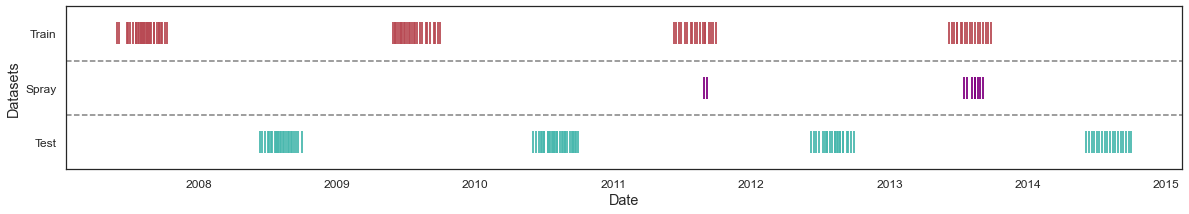

In [11]:
# Plot Timeline
fig, ax = plt.subplots(figsize = (20, 3))
sns.scatterplot(data = date_range, x = "Date", y = 'Train', ax = ax, marker = '|', s = 500)
sns.scatterplot(data = date_range, x = "Date", y = 'Test', ax = ax, marker = '|', s = 500)
sns.scatterplot(data = date_range, x = "Date", y = 'Spray', ax = ax, color = 'purple', marker = '|', s = 500)
ax.set_ylim(0.5, 3.5)
ax.set_yticks([1,2,3])
ax.set_yticklabels(["Test", "Spray","Train"])
for i in [1.5, 2.5, 3.5]:
    plt.axhline(i, color = 'grey', linestyle='--')
ax.set_ylabel('Datasets');


Looks like the train and test datasets are segregated across different years, while the spray dataset has some overlaps with train dataset in some months on 2011 and 2013. This provides the basis to explore the the relationship between the spray dataset and the train dataset in those 2 years, to observe the effect of spray on mosquito breeding and virus.

#### Comparing train and test sets

Depending on the values present in the train and test datasets, we may have to make some changes to our training datasets, such as resampling for inbalance datasets. We will explore some difference between train and test sets.

##### Species

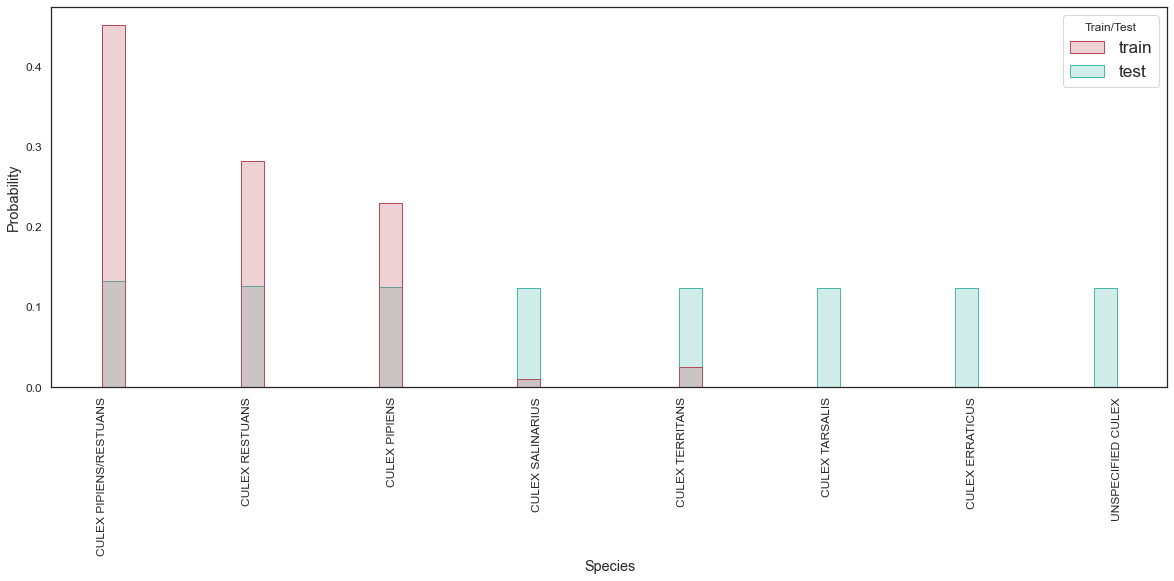

In [12]:
plot_train_test(df_train_weather_clean, df_test_weather_clean, 'Species')

Looks like we have an inbalance feature for the `Species` column, as can be seen, the species have more or less equal proportion in test data but highly inbalance in train data. We will explore the dataset further before deciding on a course of action.

##### Month

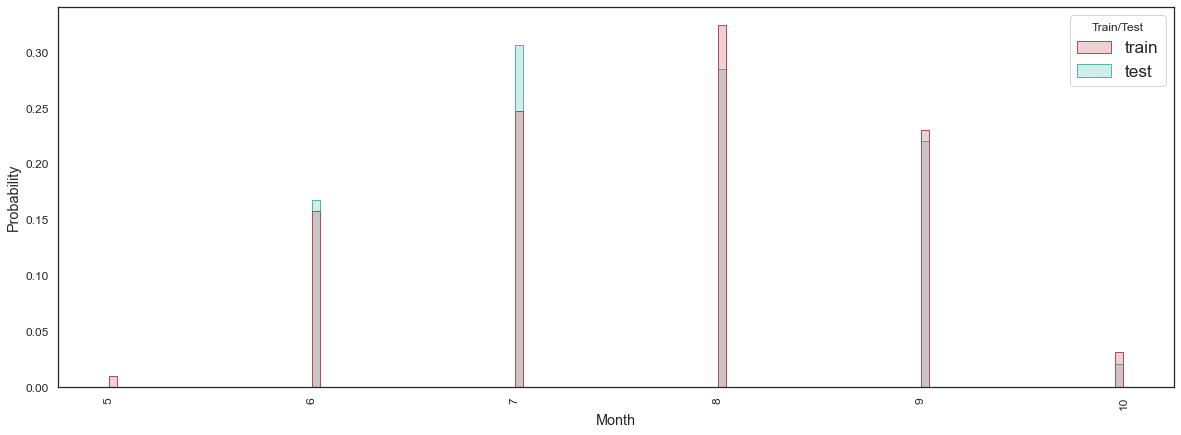

In [13]:
plot_train_test(df_train_weather_clean, df_test_weather_clean, 'Month')

##### Day of Week

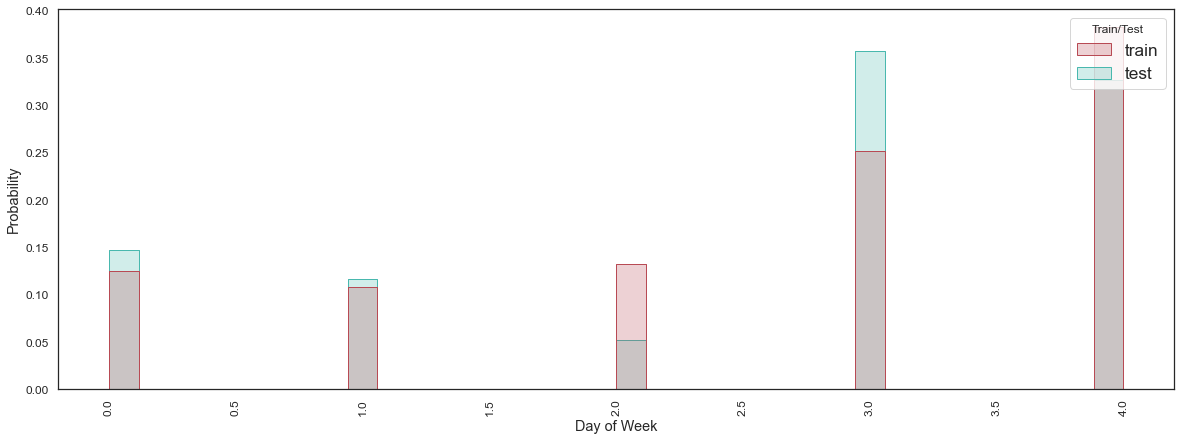

In [14]:
plot_train_test(df_train_weather_clean, df_test_weather_clean, 'Day of Week')

##### Trap

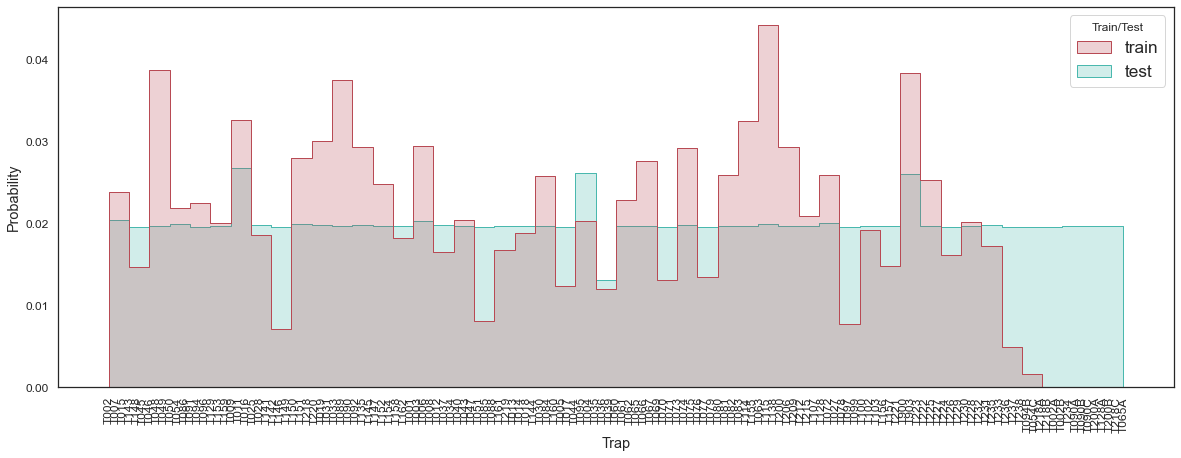

In [15]:
plot_train_test(df_train_weather_clean, df_test_weather_clean, 'Trap')

Inbalance feature is also observed for Traps data.

### Individual Features

#### Train dataset

First, we will do some basic exploration to get a feel of the individual features.

In [16]:
df_train_weather_clean['NumMosquitos'].value_counts()

1       2113
2       1171
3        803
4        540
5        432
        ... 
421        1
1054       1
231        1
1554       1
186        1
Name: NumMosquitos, Length: 232, dtype: int64

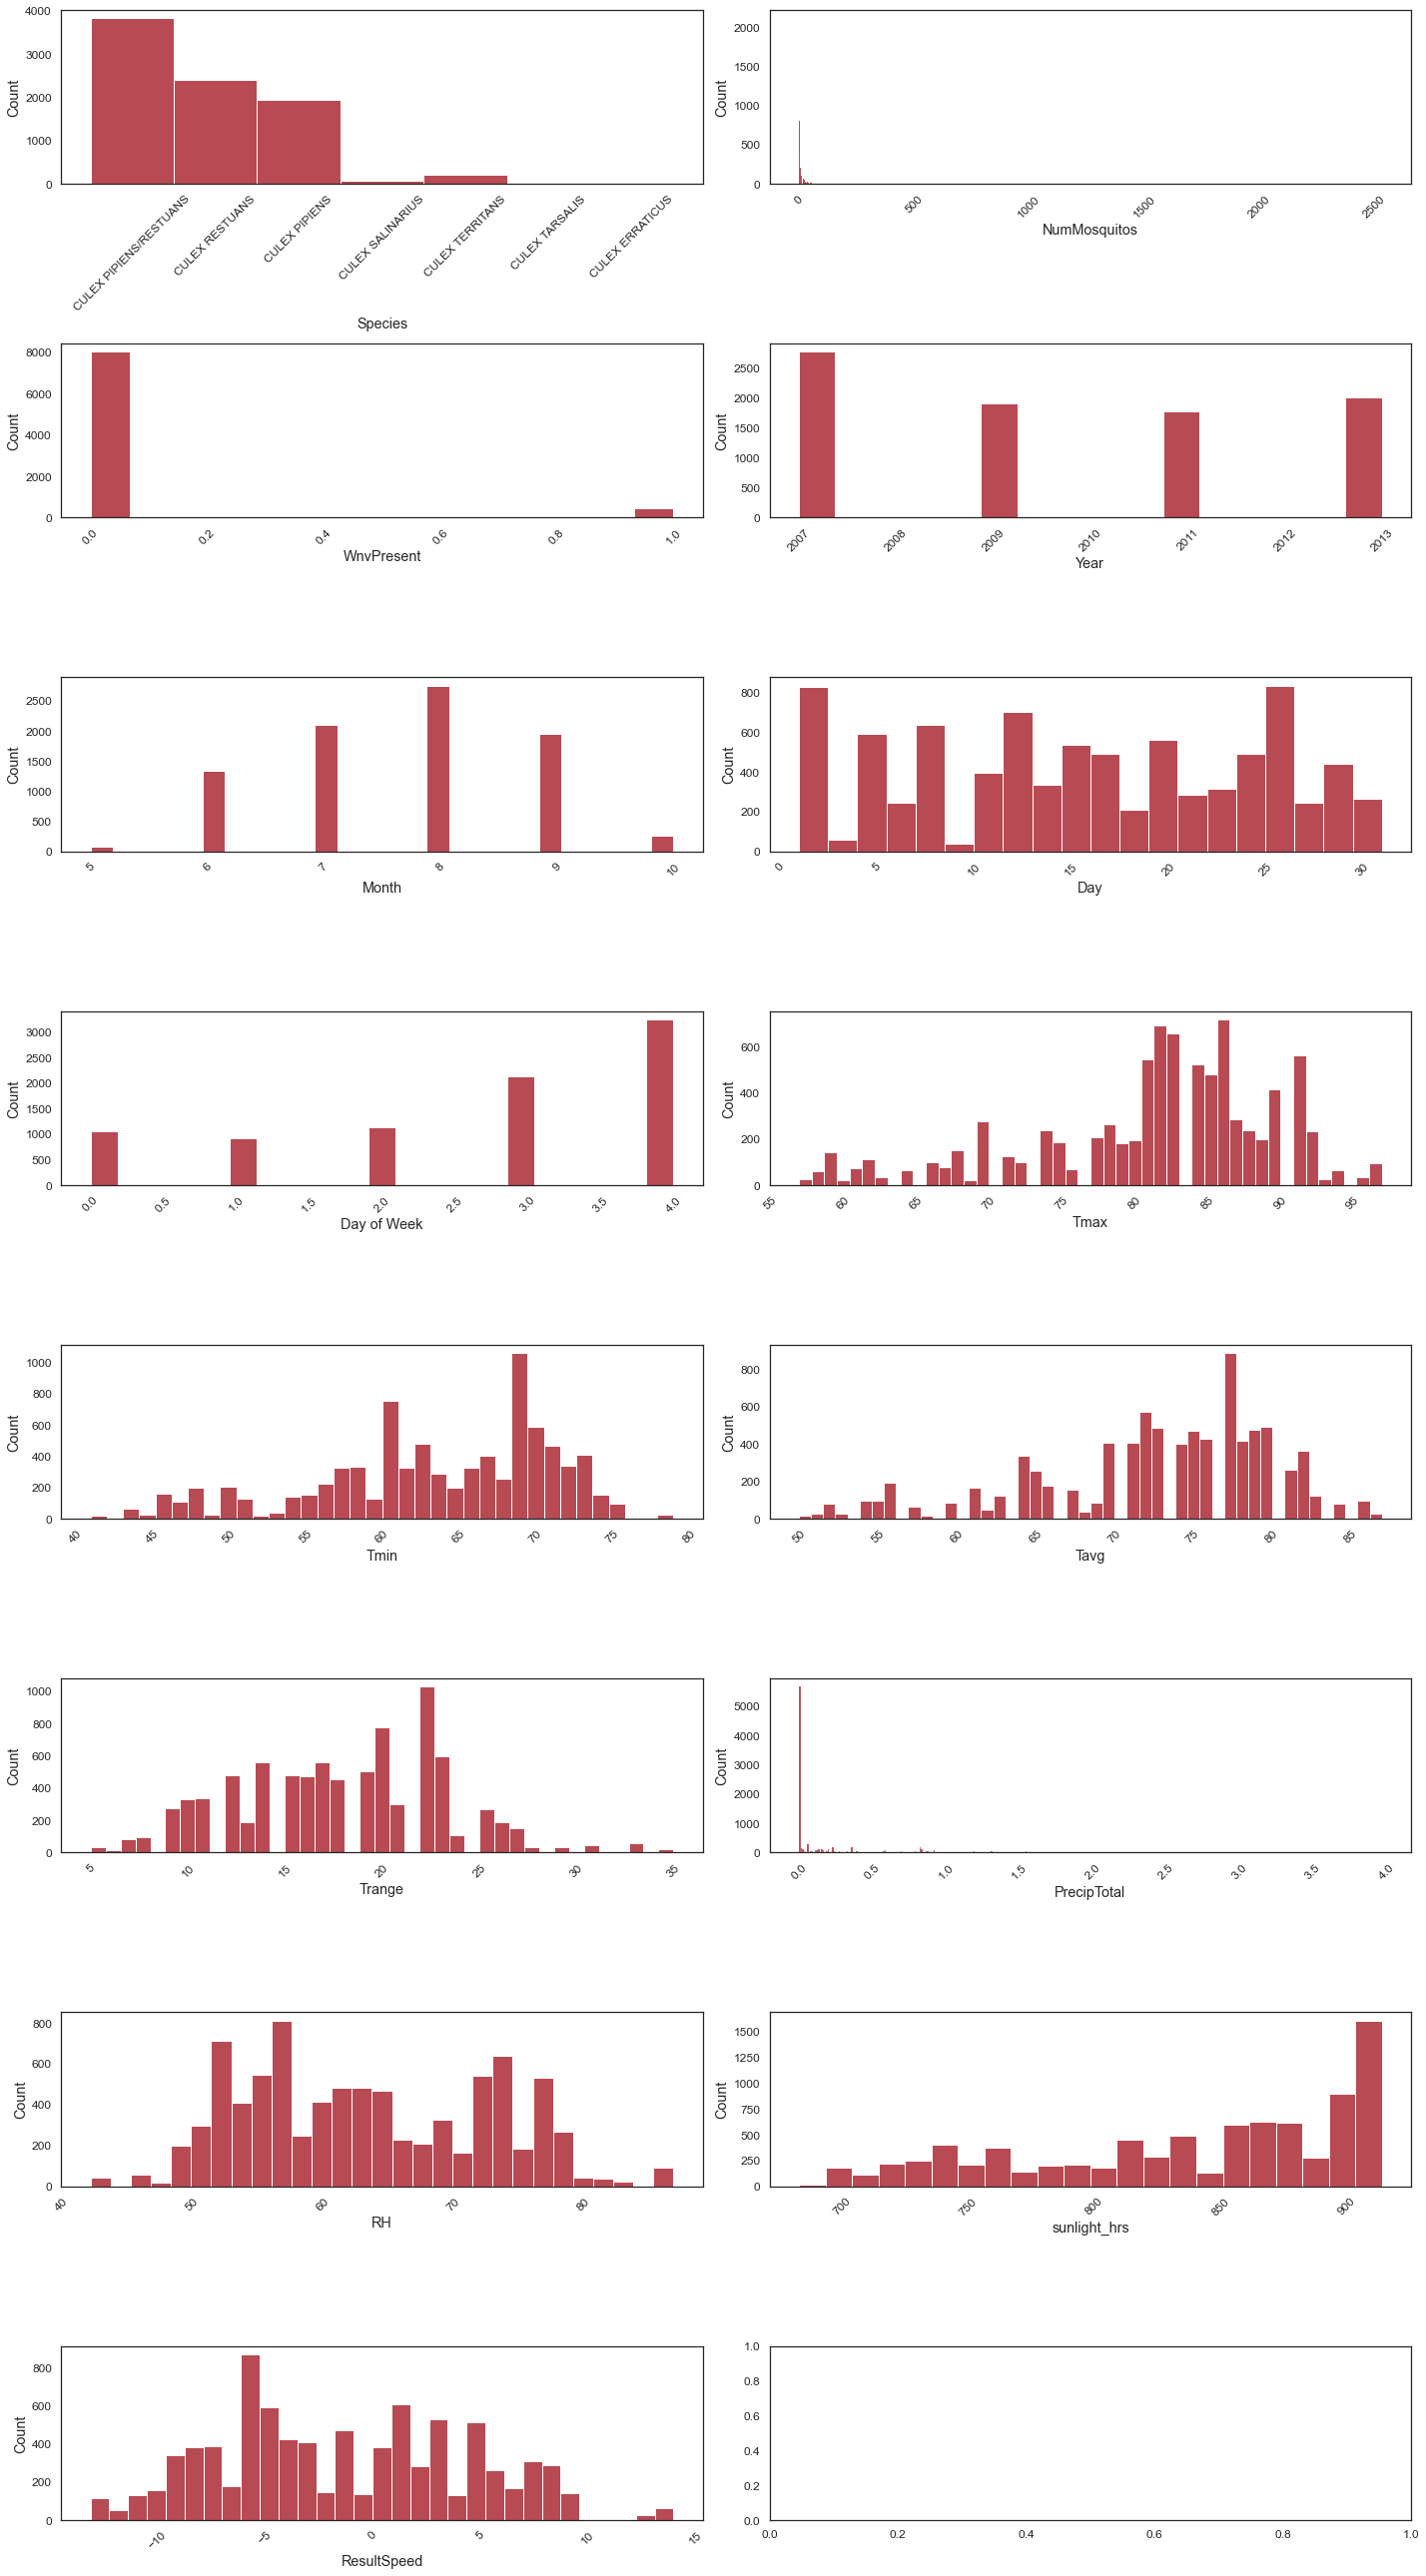

In [17]:
plot_histogram(df_train_weather_clean, ['Species', 'NumMosquitos', 'WnvPresent', 'Year', 'Month',
                                       'Day', 'Day of Week', 'Tmax', 'Tmin', 'Tavg', 'Trange', 'PrecipTotal', 'RH', 'sunlight_hrs', 'ResultSpeed'], 0.45)

**Some interesting observations**

- We observe that the response variable, `WnvPresent` is highly inbalance. 

- In terms of `Species`, Culex Pippens and Culex Restuan are the majority species of mosquitoes caught in the traps.

- Seems like the data were mainly collected in the warmer months from May to Oct

- The data were collected only on weekdays

For weather data, there seems like there is no clear observable trend just by looking at the histograms. However, we do note that the months are mainly in the hotter months. Next, we will observe if there are any time series relationships.

## Incidence of WNV in different species of mosquitos

In [18]:
# By total mosquitos
df_temp_species_mos = df_train_weather_clean[['Species', 'NumMosquitos', 'WnvPresent']].groupby('Species').sum()
df_temp_species_mos['Incident Rate'] = df_temp_species_mos['WnvPresent']/ df_temp_species_mos['NumMosquitos']
df_temp_species_mos

NumMosquitos  WnvPresent  Incident Rate
Species                                                        
CULEX ERRATICUS                    7           0       0.000000
CULEX PIPIENS                  44671         184       0.004119
CULEX PIPIENS/RESTUANS         66268         225       0.003395
CULEX RESTUANS                 23431          48       0.002049
CULEX SALINARIUS                 145           0       0.000000
CULEX TARSALIS                     7           0       0.000000
CULEX TERRITANS                  510           0       0.000000

In [19]:
# By total number of traps
df_temp_species_trap = df_train_weather_clean[['Species', 
                                              'NumMosquitos', 'WnvPresent']].groupby('Species').agg({'NumMosquitos':'count',
                                                                                 'WnvPresent':'sum'}).rename({'NumMosquitos':'NumTraps'}, axis = 1)

df_temp_species_trap['Incident Rate'] = df_temp_species_trap['WnvPresent']/ df_temp_species_trap['NumTraps']
df_temp_species_trap

NumTraps  WnvPresent  Incident Rate
Species                                                    
CULEX ERRATICUS                1           0       0.000000
CULEX PIPIENS               1950         184       0.094359
CULEX PIPIENS/RESTUANS      3826         225       0.058808
CULEX RESTUANS              2393          48       0.020059
CULEX SALINARIUS              83           0       0.000000
CULEX TARSALIS                 6           0       0.000000
CULEX TERRITANS              216           0       0.000000

## Temporal Relationships

### Temporal relationships with response variables (NumMosquitos, WnvPresent)

We will first explore how the number of mosquitoes and WnvPresent change across time, together with some of the weather features.

#### Monthly

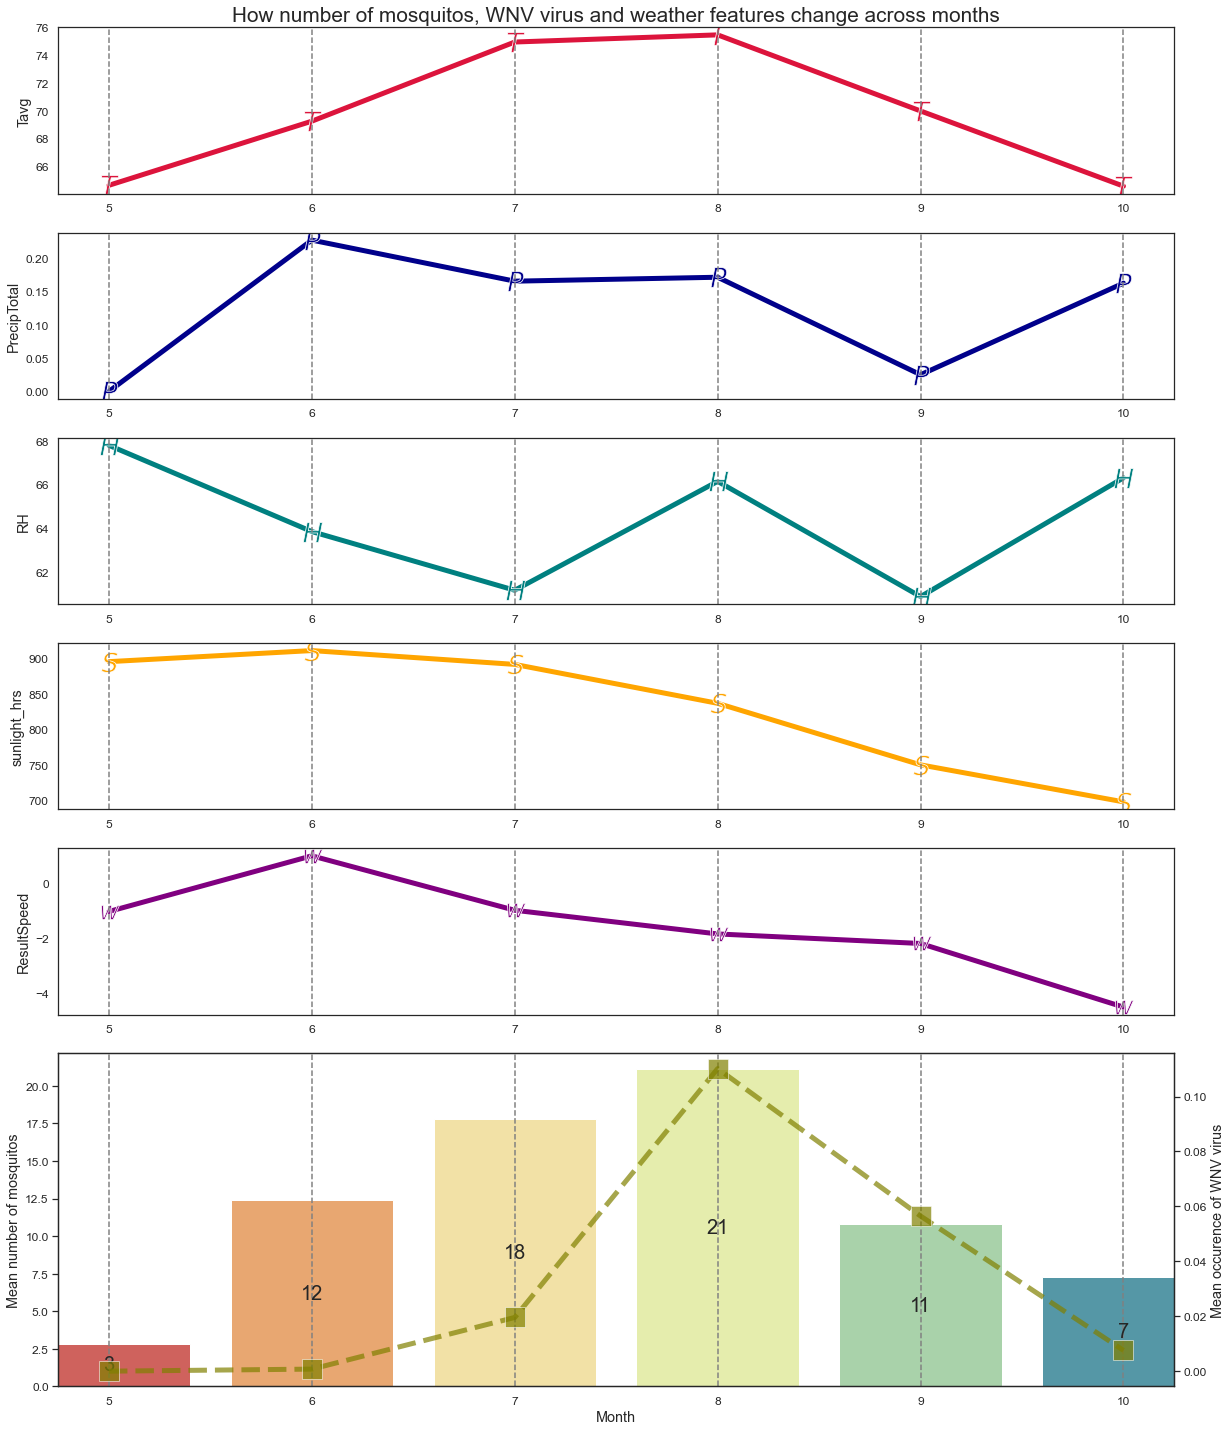

In [20]:
# Plot monthly NumMosquitos and WnvPresent with weather features

fig = plt.figure(figsize = (20,25))

# create 6 plots
grid = gs.GridSpec(6,1, height_ratios=[1,1,1,1,1,2])

ax0 = plt.subplot(grid[0])
ax1 = plt.subplot(grid[1])
ax2 = plt.subplot(grid[2])
ax3 = plt.subplot(grid[3])
ax4 = plt.subplot(grid[4])

ax5 = plt.subplot(grid[5])
ax6 =ax5.twinx() # bottom most plot will have 2 y-axis

all_ax = [ax0, ax1, ax2, ax3, ax4, ax5, ax6]

# get sum and mean of different features grouped by month
df_temp_tavg = df_train_weather_clean[['Year', 'Month', 'Tavg', 'PrecipTotal', 'RH', 'sunlight_hrs', 
                                       'ResultSpeed', 'NumMosquitos', 'WnvPresent']].groupby('Month').agg({'Tavg':'mean',
                                                                            'PrecipTotal':'mean',
                                                                            'RH':'mean',
                                                                            'sunlight_hrs':'mean',
                                                                            'ResultSpeed':'mean',
                                                                           'NumMosquitos':'mean',
                                                                           'WnvPresent':'mean'}).reset_index()
# Average temperature
line_Tavg = sns.lineplot(data = df_temp_tavg, x = df_temp_tavg['Month'], y = 'Tavg', color = 'crimson', 
                   ax = ax0, linewidth = 5, marker = '$T$', markersize = 20)

# Precipitation
line_Prec = sns.lineplot(data = df_temp_tavg, x = df_temp_tavg['Month'], y = 'PrecipTotal', 
                         color = 'darkblue', ax = ax1, linewidth = 5, marker = '$P$', markersize = 20)

# RH
line_Prec = sns.lineplot(data = df_temp_tavg, x = df_temp_tavg['Month'], y = 'RH', 
                         color = 'teal', ax = ax2, linewidth = 5, marker = '$H$', markersize = 20)

# sunlight_hrs
line_Prec = sns.lineplot(data = df_temp_tavg, x = df_temp_tavg['Month'], y = 'sunlight_hrs', 
                         color = 'orange', ax = ax3, linewidth = 5, marker = '$S$', markersize = 20)

# ResultSpeed
line_Prec = sns.lineplot(data = df_temp_tavg, x = df_temp_tavg['Month'], y = 'ResultSpeed', 
                         color = 'purple', ax = ax4, linewidth = 5, marker = '$W$', markersize = 20)

# NumMosquitos
bar_NumM = sns.barplot(data = df_temp_tavg, x = 'Month', y = 'NumMosquitos', palette="Spectral", 
                  ax = ax5)

bar_NumM.bar_label(bar_NumM.containers[0], fontsize = 20, padding = 0, fmt = '%.0f', label_type ='center')

ax5.set_xlim(-0.25,5.25) # align x-axis

# WnvPresent
line_WnvPresent = sns.lineplot(data = df_temp_tavg, x = df_temp_tavg['Month']-len(df_temp_tavg['Month'])+1, y = 'WnvPresent', color = 'olive', 
                   ax = ax6, linewidth = 5, marker = 's', markersize = 20, alpha = 0.7)
ax6.lines[0].set_linestyle("--") # set as dotted line

# Plot dotted lines on month and make label invisible for month
for ax in all_ax[:-2]: 
    for m in df_temp_tavg['Month']:
        ax.axvline(m, color = 'grey', linestyle='--')
    ax.xaxis.label.set_visible(False) # make xlabel invisible
    
for m in df_temp_tavg['Month']-5:
    ax5.axvline(m, color = 'grey', linestyle='--')

ax5.set_ylabel("Mean number of mosquitos")
ax6.set_ylabel("Mean occurence of WNV virus")
ax0.set_title("How number of mosquitos, WNV virus and weather features change across months");

We will also see the monthly trend for different species of mosquitos

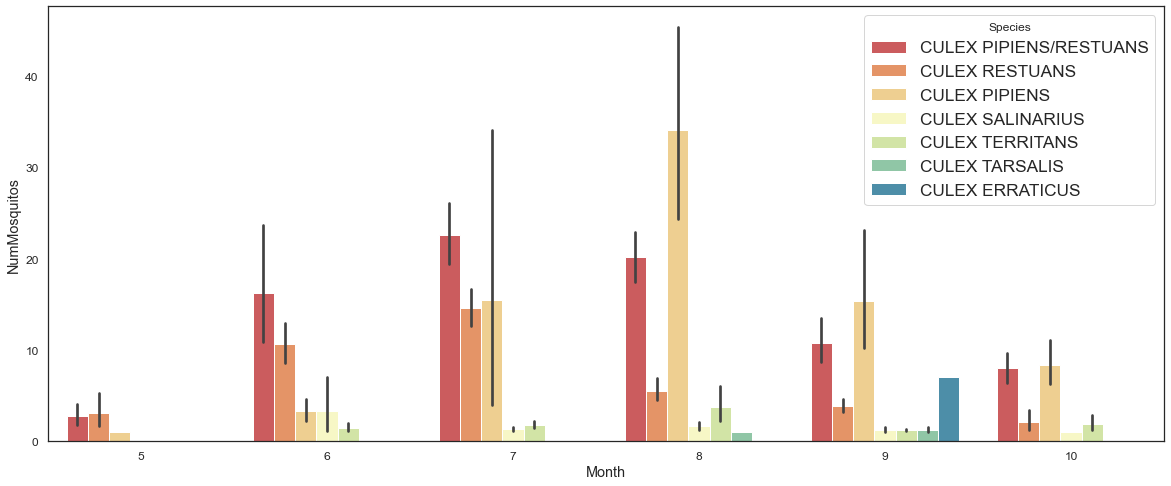

In [21]:
fig, ax = plt.subplots(figsize = (20, 8))

sns.barplot(data = df_train_weather_clean, x = 'Month', y = 'NumMosquitos', 
             hue = 'Species', palette="Spectral", estimator = np.mean);

#### Year

We will also see if the monthly trend is consistent across all years.

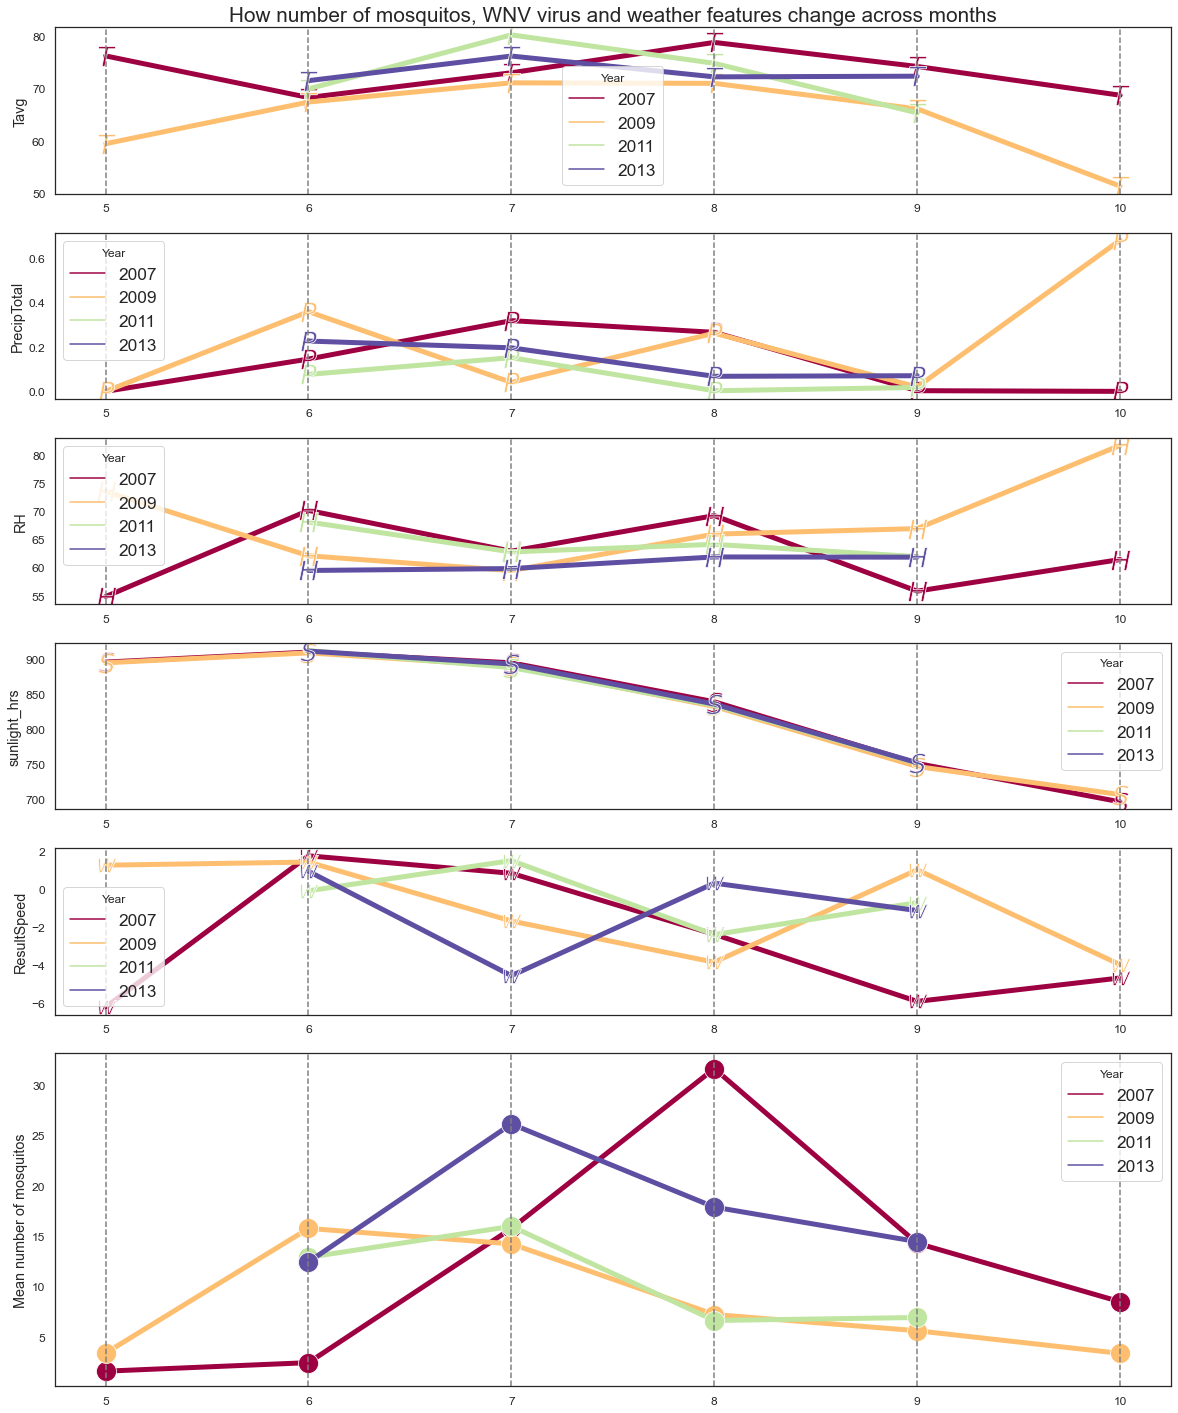

In [22]:
# Plot monthly NumMosquitos and WnvPresent with weather features

fig = plt.figure(figsize = (20,25))

# create 6 plots
grid = gs.GridSpec(6,1, height_ratios=[1,1,1,1,1,2])

ax0 = plt.subplot(grid[0])
ax1 = plt.subplot(grid[1])
ax2 = plt.subplot(grid[2])
ax3 = plt.subplot(grid[3])
ax4 = plt.subplot(grid[4])

ax5 = plt.subplot(grid[5])

all_ax = [ax0, ax1, ax2, ax3, ax4, ax5, ax6]


# Average temperature
line_Tavg = sns.lineplot(data = df_train_weather_clean, x = 'Month', y = 'Tavg', hue = 'Year', palette='Spectral',
                   ax = ax0, linewidth = 5, marker = '$T$', markersize = 20, ci = None)

# Precipitation
line_Prec = sns.lineplot(data = df_train_weather_clean, x = 'Month', y = 'PrecipTotal', hue = 'Year', palette='Spectral',
                         color = 'darkblue', ax = ax1, linewidth = 5, marker = '$P$', markersize = 20, ci = None)

# RH
line_Prec = sns.lineplot(data = df_train_weather_clean, x = 'Month', y = 'RH', hue = 'Year', palette='Spectral',
                         color = 'teal', ax = ax2, linewidth = 5, marker = '$H$', markersize = 20, ci = None)

# sunlight_hrs
line_Prec = sns.lineplot(data = df_train_weather_clean, x = 'Month', y = 'sunlight_hrs',hue = 'Year', palette='Spectral', 
                         color = 'orange', ax = ax3, linewidth = 5, marker = '$S$', markersize = 20, ci = None)

# ResultSpeed
line_Prec = sns.lineplot(data = df_train_weather_clean, x = 'Month', y = 'ResultSpeed', hue = 'Year', palette='Spectral',
                         color = 'purple', ax = ax4, linewidth = 5, marker = '$W$', markersize = 20, ci = None)

# NumMosquitos
bar_NumM = sns.lineplot(data = df_train_weather_clean, x = 'Month', y = 'NumMosquitos', hue = 'Year', palette='Spectral', 
                  ax = ax5, linewidth = 5, marker = 'o', markersize = 20, ci = None)

#bar_NumM.bar_label(bar_NumM.containers[0], fontsize = 20, padding = 0, fmt = '%.0f', label_type ='center')

#ax5.set_xlim(-0.25,5.25) # align x-axis

# WnvPresent
"""line_WnvPresent = sns.lineplot(data = df_temp_tavg, x = df_temp_tavg['Month']-len(df_temp_tavg['Month'])+1, y = 'WnvPresent', color = 'olive', 
                   ax = ax6, linewidth = 5, marker = 's', markersize = 20, alpha = 0.7)
ax6.lines[0].set_linestyle("--") # set as dotted line"""

# Plot dotted lines on month and make label invisible for month
for ax in all_ax: 
    for m in df_temp_tavg['Month']:
        ax.axvline(m, color = 'grey', linestyle='--')
    ax.xaxis.label.set_visible(False) # make xlabel invisible
    
ax5.set_ylabel("Mean number of mosquitos")
ax6.set_ylabel("Mean occurence of WNV virus")
ax0.set_title("How number of mosquitos, WNV virus and weather features change across months");

<AxesSubplot:xlabel='Month', ylabel='NumMosquitos'>

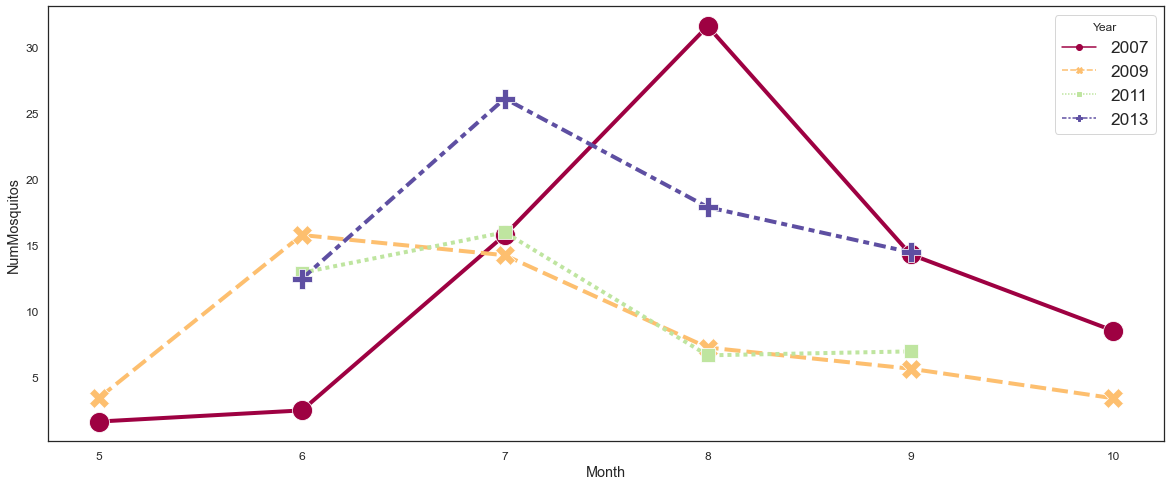

In [23]:
# Mean NumMosquitoes across months for different years
fig, ax = plt.subplots(figsize = (20, 8))

sns.lineplot(data=df_train_weather_clean, x = 'Month', y = 'NumMosquitos', ci = None, estimator=np.mean,
            hue = 'Year', ax = ax, palette='Spectral', linewidth = 4, style = 'Year', markers=True,
            markersize = 20)

We see that in general, the number of mosquitos trapped peaked from June to Aug.

#### Days of Week

We will also see if there are certain observable patterns in terms of days of week.

In [24]:
# See number of datapoints on each day of week
df_train_weather_clean['Day of Week'].value_counts().sort_values(ascending = True)

1     918
0    1058
2    1122
3    2133
4    3244
Name: Day of Week, dtype: int64

In [25]:
# See the highest number of mosquitos
df_train_weather_clean[['Day of Week', 'NumMosquitos']].sort_values(by = 'NumMosquitos', ascending = False).head()

Day of Week  NumMosquitos
1450            3          2532
565             2          2356
1901            1          2207
1196            2          1658
2055            2          1648

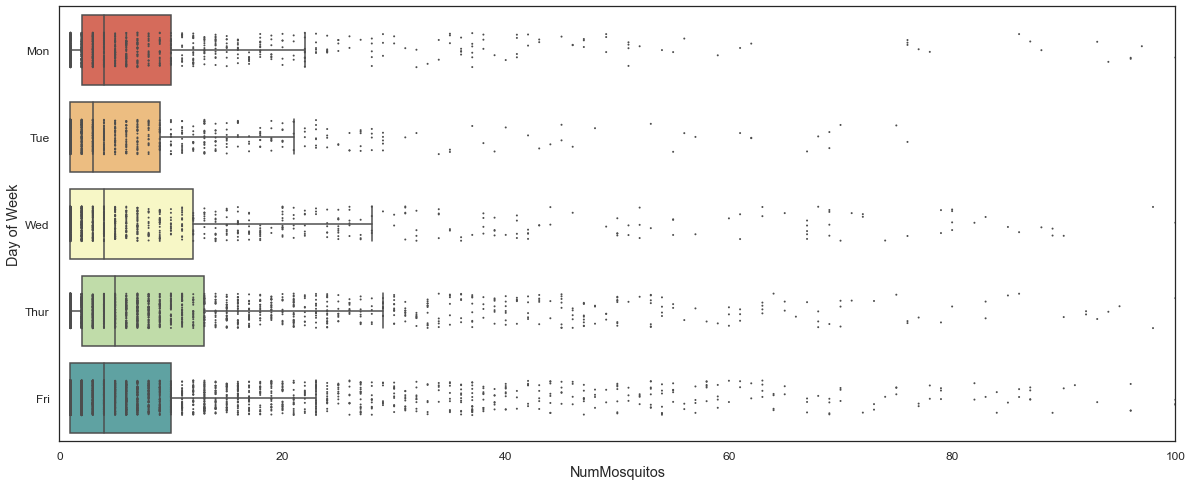

In [26]:
# Mean NumMosquitoes across days of week
fig, ax = plt.subplots(figsize = (20, 8))
sns.boxplot(data = df_train_weather_clean, x = 'NumMosquitos', y = 'Day of Week',
           palette='Spectral', orient = 'h', showfliers = False, ax = ax)
sns.stripplot(y="Day of Week", x="NumMosquitos", data=df_train_weather_clean,
              size=2, color=".3", orient = 'h', jitter = 0.2, linewidth=0, ax = ax)
ax.set_xlim(0,100)
ax.set_yticklabels(['Mon', 'Tue', 'Wed', 'Thur', 'Fri']);

- We see that most data points were collected on Fri, and least on Tue. We will further explore this to see if it may to due to the collection date of traps.

- Most data tend to concentrate on the lower ranges, i.e. below 100 mosquitos a day, but it can go as high as 2532. We will explore further if the high numbers were concentrated around a certain period.

- Overall, higher mosquito numbers tend to be recorded on Wed and Thur, but the trend is not obvious.

Let us take a finer grain look to see the distribution across different traps.

In [27]:
# Get the number of mosquitos per day of week by trap
df_temp_traps_DoW_numM = df_train_weather_clean[['Day of Week', 'Trap', 'NumMosquitos']]
df_temp_traps_DoW_numM_gb = df_temp_traps_DoW_numM.groupby(['Trap', 'Day of Week']).sum().reset_index()
df_temp_traps_DoW_numM_gb = df_temp_traps_DoW_numM_gb.pivot(index = 'Trap', columns='Day of Week', values = 'NumMosquitos').T
df_temp_traps_DoW_numM_gb.head()

# Get the times the traps data were recorded by day of week
df_temp_traps_DoW = df_train_weather_clean[['Day of Week', 'Trap', 'NumMosquitos']].rename({'NumMosquitos':'Count'}, axis = 1)
df_temp_traps_DoW_gb = df_temp_traps_DoW.groupby(['Trap', 'Day of Week']).count().reset_index()
df_temp_traps_DoW_gb = df_temp_traps_DoW_gb.pivot(index = 'Trap', columns='Day of Week', values = 'Count').T
df_temp_traps_DoW_gb.head()

# Normalize number of mosquitoes by number of traps
df_temp_traps_DoW_norm = df_temp_traps_DoW_numM_gb/df_temp_traps_DoW_gb

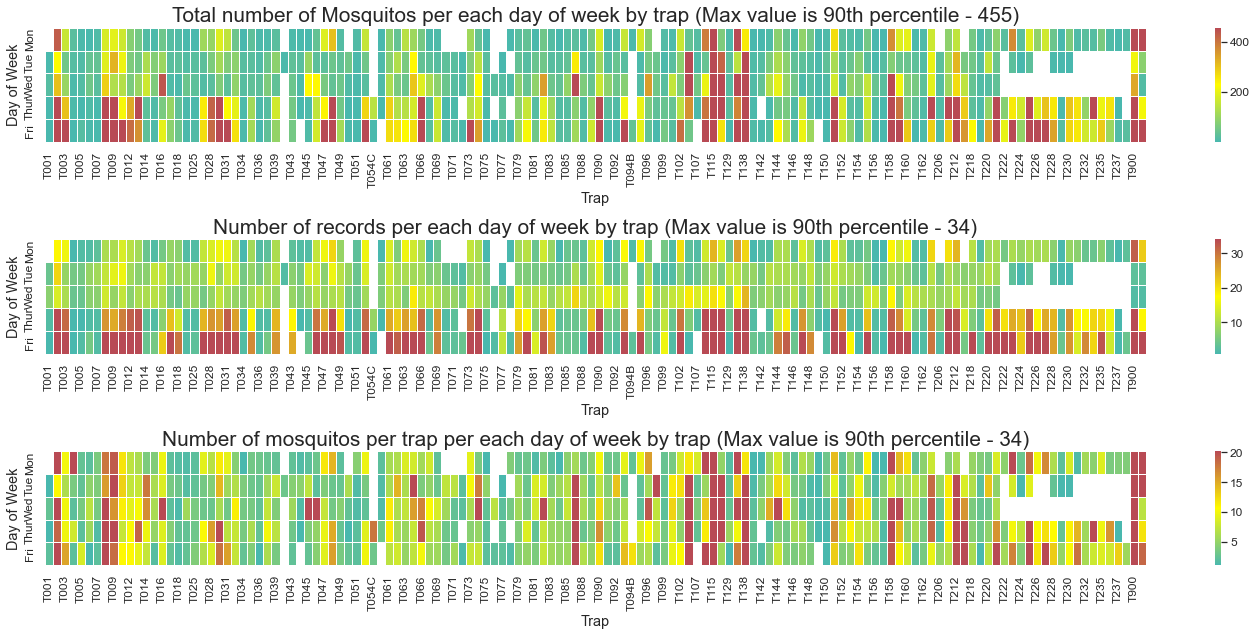

In [28]:
# Top plot: num of mosquitos by day of week by trap
fig, ax = plt.subplots(3,1, figsize=(20, 9))
sns.heatmap(df_temp_traps_DoW_numM_gb, linewidths=1, cmap = rb_cmap, 
            vmax=np.percentile((df_temp_traps_DoW_numM_gb.values)[~np.isnan(df_temp_traps_DoW_numM_gb.values)], 90),
            ax =ax[0])
ax[0].set_title("Total number of Mosquitos per each day of week by trap (Max value is 90th percentile - 455)")
ax[0].set_yticklabels(['Mon', 'Tue', 'Wed', 'Thur', 'Fri']);

# Mid plot: num of observations by day of week by trap
sns.heatmap(df_temp_traps_DoW_gb, linewidths=1, cmap = rb_cmap, 
            vmax=np.percentile((df_temp_traps_DoW_gb.values)[~np.isnan(df_temp_traps_DoW_gb.values)], 90), 
            ax =ax[1])
ax[1].set_title("Number of records per each day of week by trap (Max value is 90th percentile - 34)")
ax[1].set_yticklabels(['Mon', 'Tue', 'Wed', 'Thur', 'Fri']);

# Mid plot: num of observations per trap by day of week by trap
sns.heatmap(df_temp_traps_DoW_norm, linewidths=1, cmap = rb_cmap, 
            vmax=np.percentile((df_temp_traps_DoW_norm.values)[~np.isnan(df_temp_traps_DoW_norm.values)], 90), 
            ax =ax[2])
ax[2].set_title("Number of mosquitos per trap per each day of week by trap (Max value is 90th percentile - 34)")
ax[2].set_yticklabels(['Mon', 'Tue', 'Wed', 'Thur', 'Fri']);

plt.tight_layout();

Here we see that certain traps capture way more mosquitos than others, we will take note of this and later we will see if a geographical trend exists.

We see that for most traps, they are represented across most days of the week. Although generally there is a higher representation of traps on Thursdays and Fridays.

After normalizing te number of mosquitos by the number of traps, we see that there are not so much variation in terms of the number of days. However, certain traps consistently traps more mosquitos, we will explore these further to see if there are spatial relations.

#### Days

We will take a finer grain look at the data across days of a year.

In [29]:
df_train_weather_clean_subset = df_train_weather_clean[['Date', 'Year', 'Month', 'Tmin', 'Tmax', 'Trange', 'Tavg', 'PrecipTotal', 'RH', 'sunlight_hrs', 
                                       'ResultSpeed', 'NumMosquitos', 'WnvPresent']]
#df_train_weather_clean_subset_2007 = df_train_weather_clean_subset[df_train_weather_clean_subset['Year'] == 2007]
#df_train_weather_clean_subset_2009 = df_train_weather_clean_subset[df_train_weather_clean_subset['Year'] == 2009]
#df_train_weather_clean_subset_2011 = df_train_weather_clean_subset[df_train_weather_clean_subset['Year'] == 2011]
#df_train_weather_clean_subset_2013 = df_train_weather_clean_subset[df_train_weather_clean_subset['Year'] == 2013]

df_train_weather_clean_subset['Date'] = df_train_weather_clean_subset['Date'].dt.strftime('%m%d')
df_train_weather_clean_subset.head()

Date  Year  Month  Tmin  Tmax  Trange  Tavg  PrecipTotal         RH  \
0  0529  2007      5    60    88      28    74          0.0  57.398449   
1  0529  2007      5    60    88      28    74          0.0  57.398449   
2  0529  2007      5    60    88      28    74          0.0  57.398449   
3  0529  2007      5    60    88      28    74          0.0  57.398449   
4  0529  2007      5    60    88      28    74          0.0  57.398449   

   sunlight_hrs  ResultSpeed  NumMosquitos  WnvPresent  
0         896.0    -6.316357             1           0  
1         896.0    -6.316357             1           0  
2         896.0    -6.316357             1           0  
3         896.0    -6.316357             1           0  
4         896.0    -6.316357             4           0

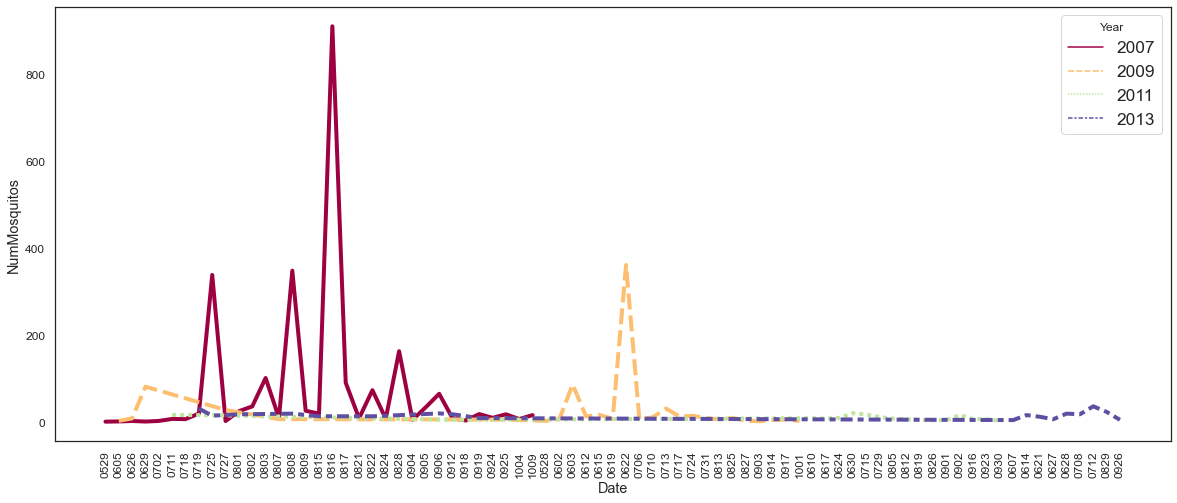

In [30]:
fig, ax = plt.subplots(figsize = (20, 8))
sns.lineplot(data=df_train_weather_clean_subset, x = 'Date', y = 'NumMosquitos', ci = None, estimator=np.mean,
            hue = 'Year', ax = ax, palette='Spectral', linewidth = 4, style = 'Year')
plt.xticks(rotation = 90);

## Feature relation with response (NumMosquitos)

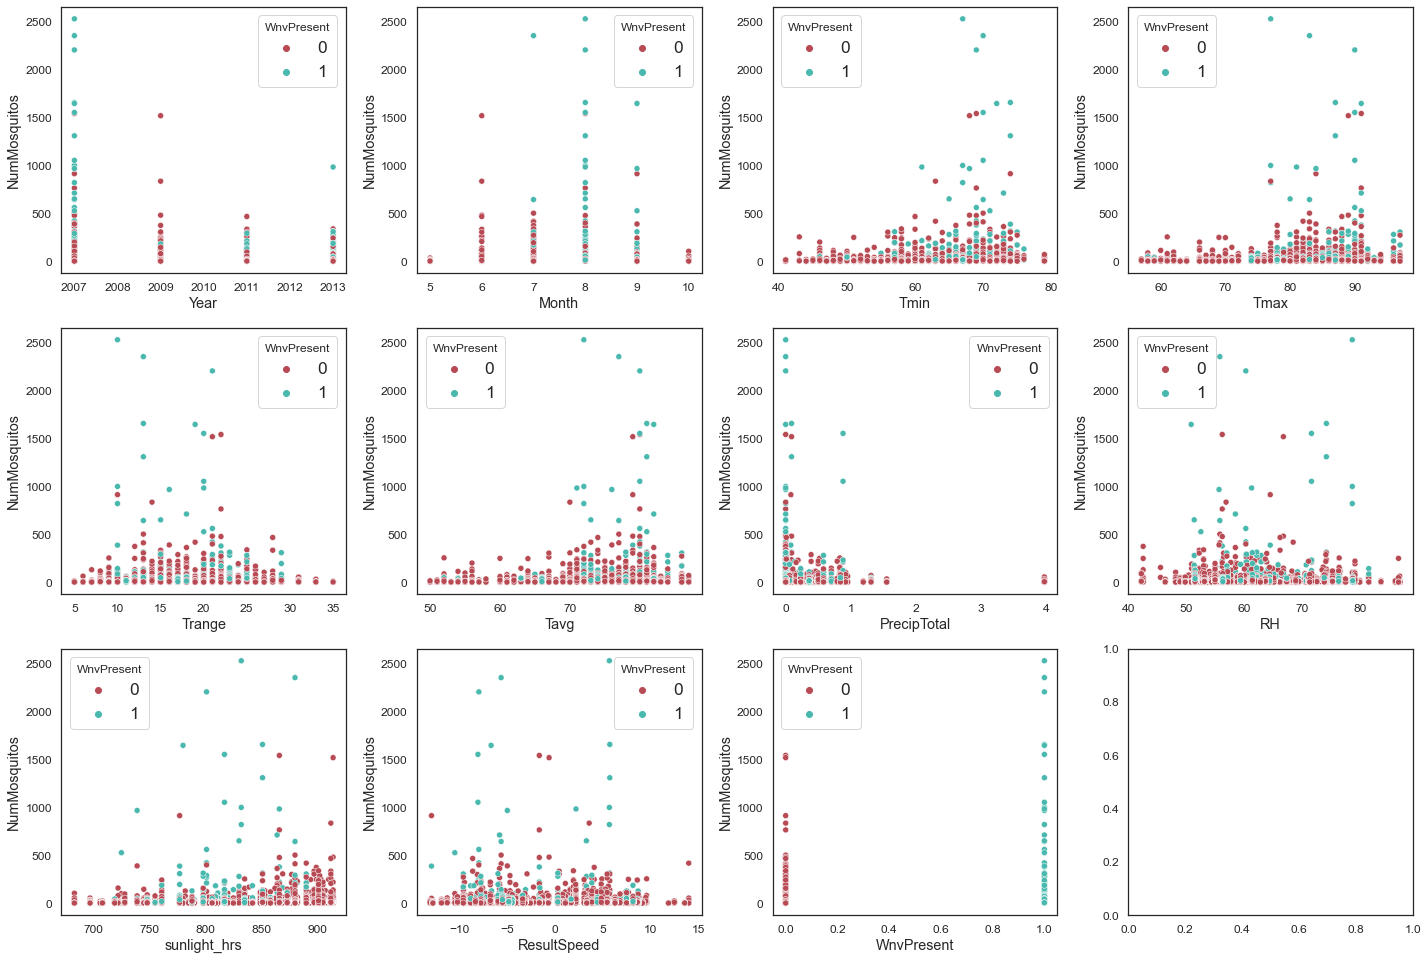

In [31]:
plot_scatterplot(df_train_weather_clean_subset, ['Year', 'Month', 'Tmin', 'Tmax', 'Trange', 'Tavg', 'PrecipTotal', 'RH', 'sunlight_hrs', 
                                       'ResultSpeed', 'WnvPresent'], 'NumMosquitos', 'WnvPresent')

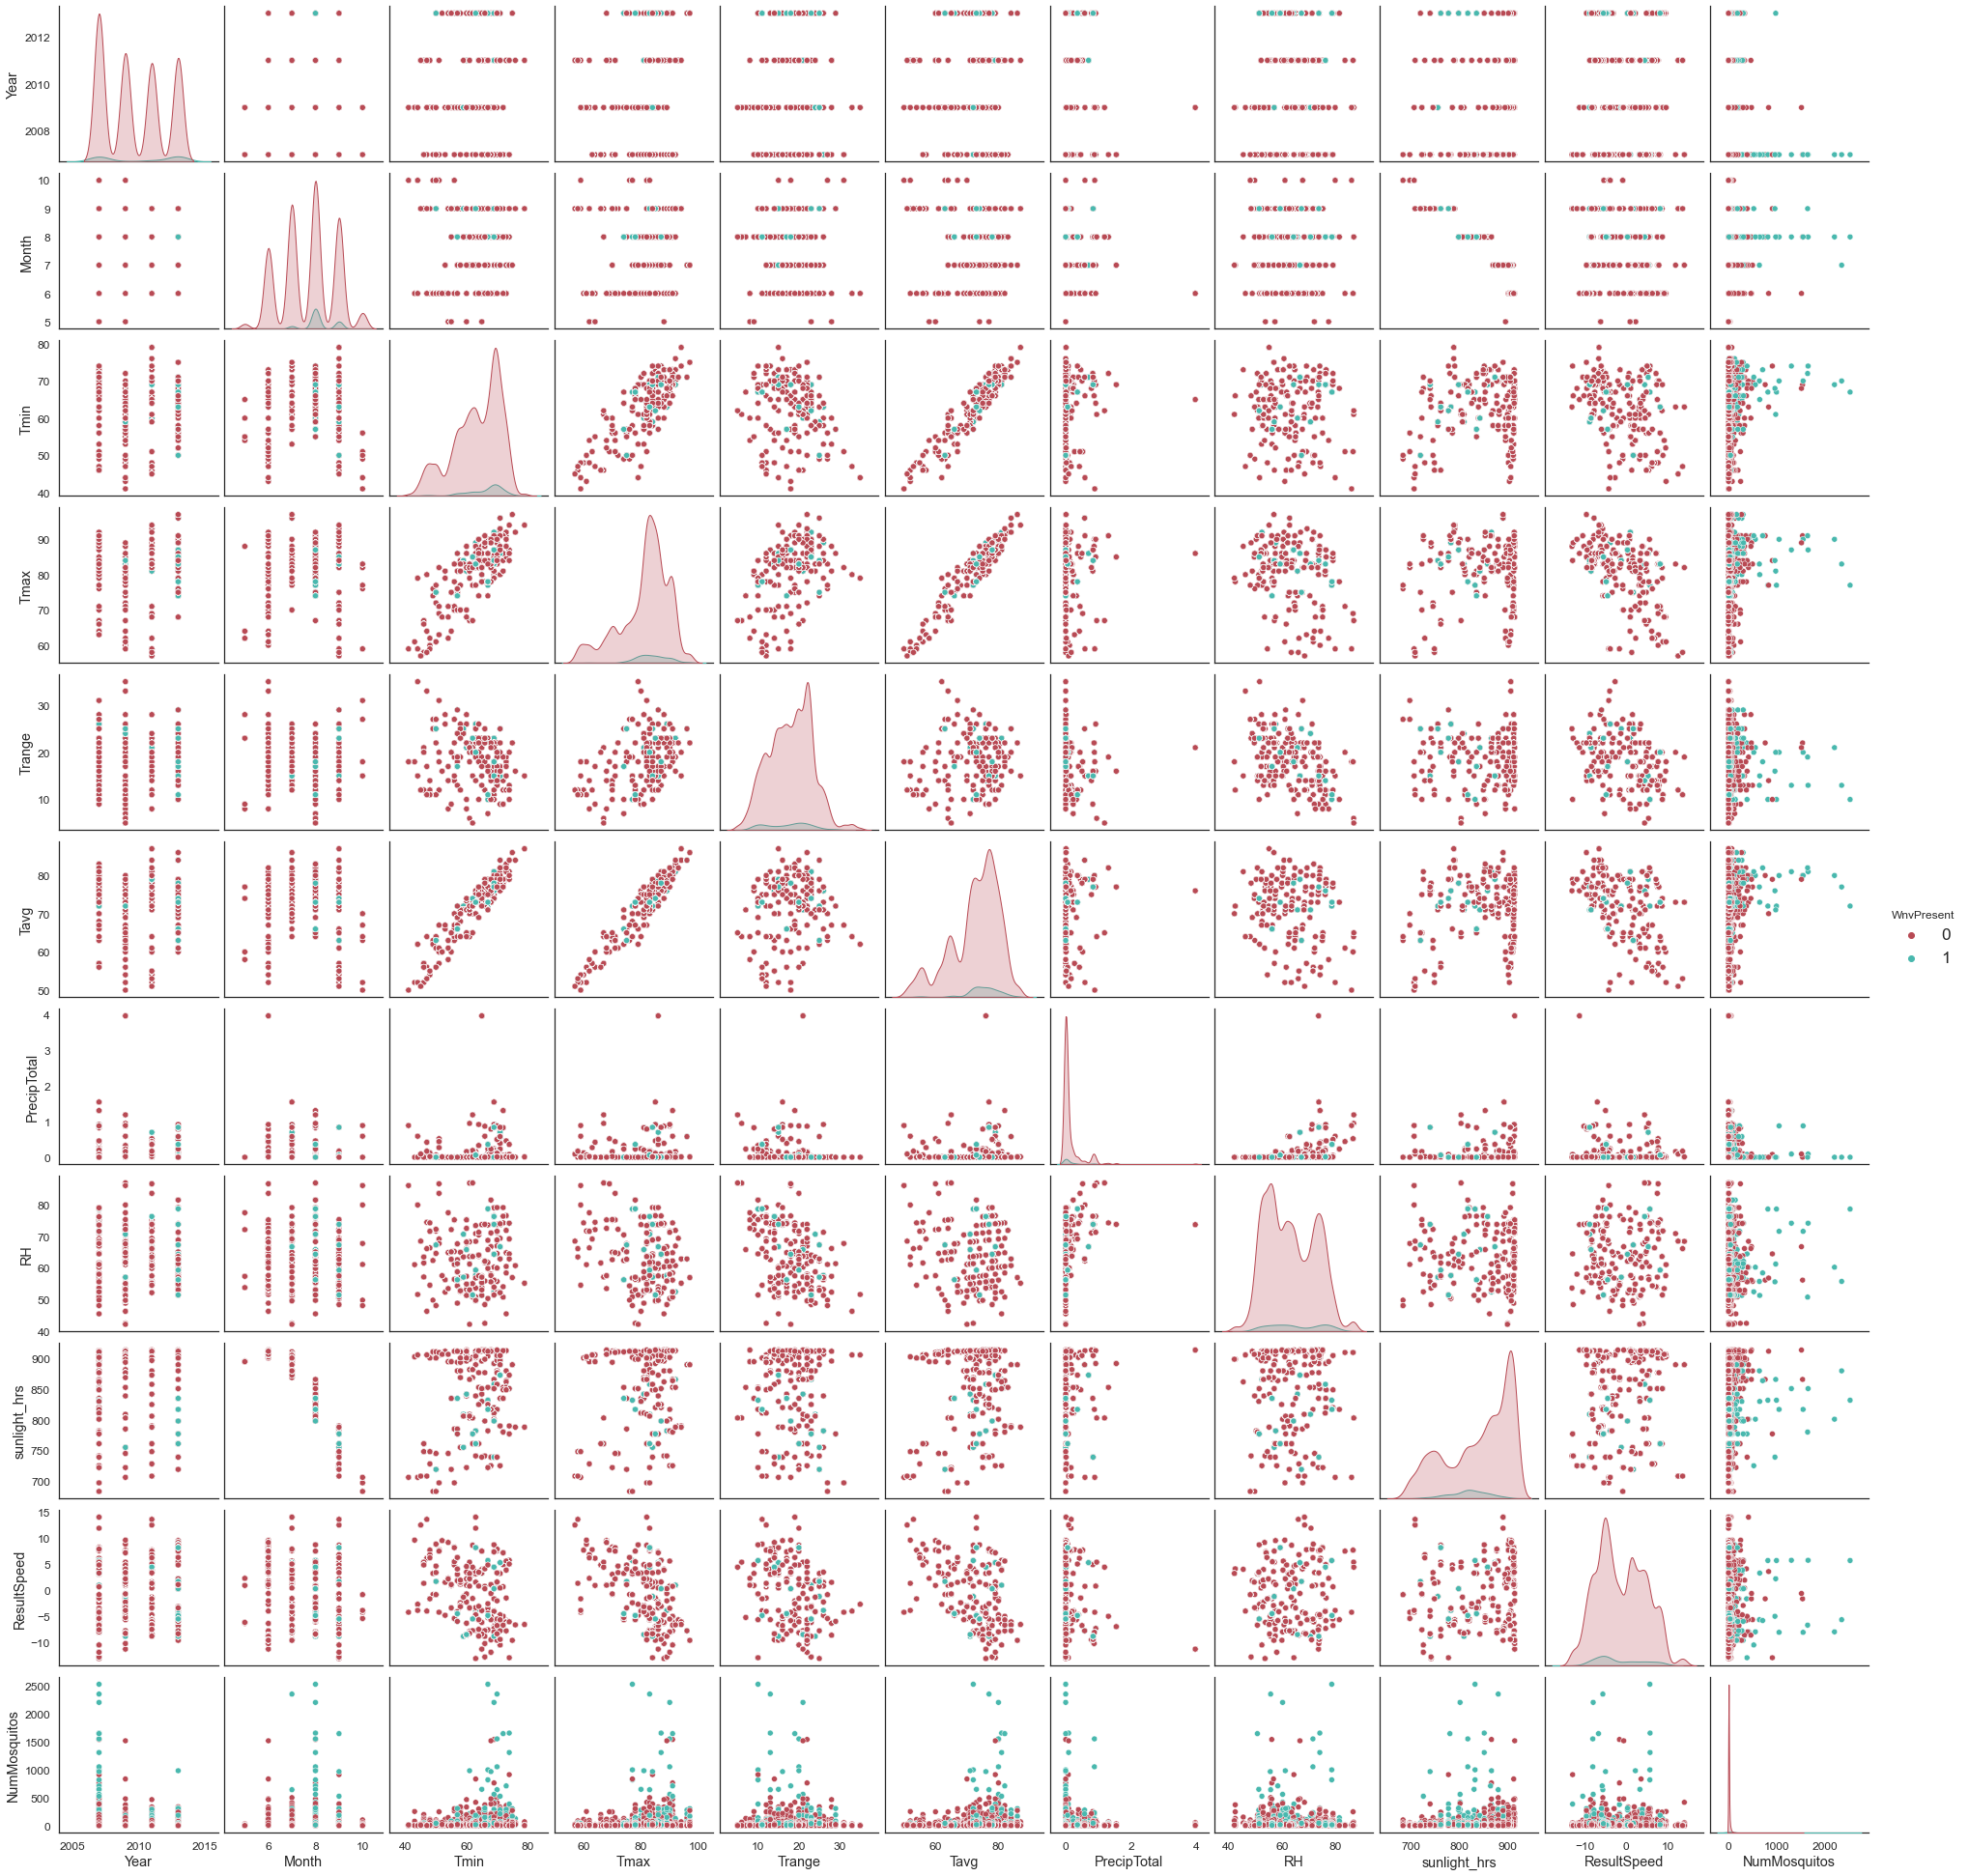

In [32]:
sns.pairplot(df_train_weather_clean_subset, hue = 'WnvPresent')

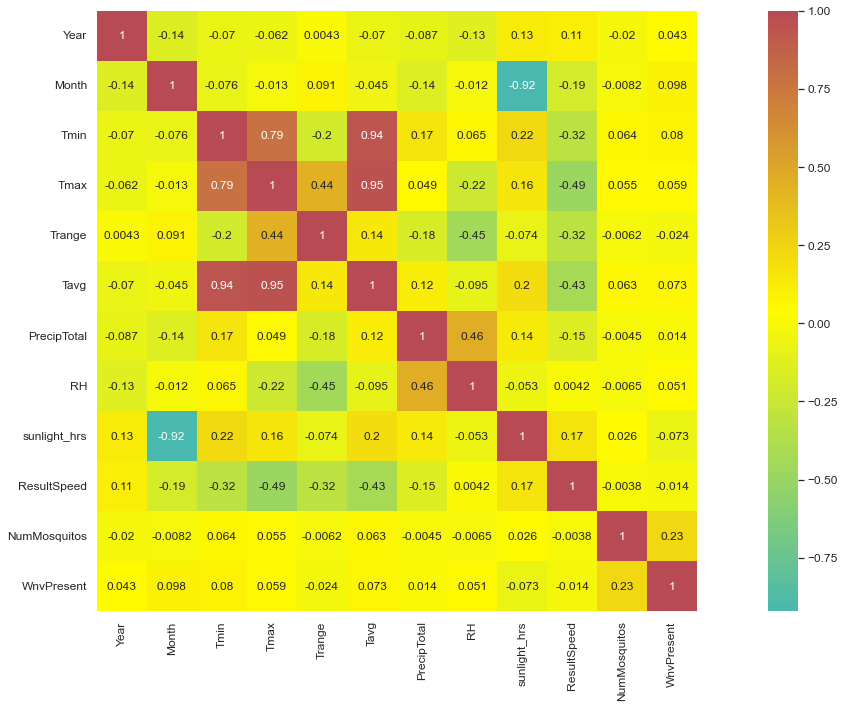

In [33]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(df_train_weather_clean_subset.corr(), square=True, annot = True, cmap=rb_cmap, ax=ax)
plt.tight_layout()

From the series of plots, we do not see any especially strong linear correlation between the predictors and NumMosquitos, although we do see that for certain features such as temperature features, NumMosquitos are generally higher for higher temperatures, and more of them has WNV present.

## Spatial-temporal relationships

### Geodataframe setup

We will also create a geospatial feature called ``geometry`` from the longitude and latitude columns. This is to help us visualize the location of traps and sprays.

In [34]:
# Import chicago shp file
chicago_map = gpd.read_file('../../datasets/geospatial_data/geo_export_b6d9ff0e-93d2-4bd4-8a82-6ee748350562.shp')
crs = {'init':'epsg:3857'}
chicago_map_wm = chicago_map.to_crs(epsg=3857)
chicago_map_wm.head(3)

area area_num_1 area_numbe  comarea  comarea_id    community  perimeter  \
0   0.0         35         35      0.0         0.0      DOUGLAS        0.0   
1   0.0         36         36      0.0         0.0      OAKLAND        0.0   
2   0.0         37         37      0.0         0.0  FULLER PARK        0.0   

     shape_area     shape_len  \
0  4.600462e+07  31027.054510   
1  1.691396e+07  19565.506153   
2  1.991670e+07  25339.089750   

                                            geometry  
0  POLYGON ((-9752604.951 5137743.450, -9752605.8...  
1  POLYGON ((-9750713.852 5133595.674, -9750731.1...  
2  POLYGON ((-9754793.199 5131350.020, -9754792.7...

In [35]:
# create point features for clean
#points = [Point(xy) for xy in zip(df_train_clean['Longitude'], df_train_clean['Latitude'])]
points = gpd.points_from_xy(df_train_weather_clean['Longitude'], df_train_weather_clean['Latitude'], crs="EPSG:4326")
df_train_weather_clean_geo = gpd.GeoDataFrame(df_train_weather_clean,
                                  crs="EPSG:4326",
                                  geometry=points)
df_train_weather_clean_geo = df_train_weather_clean_geo.to_crs(epsg=3857)
df_train_weather_clean_geo.head(1)

Date  Trap                 Species  Latitude  Longitude  NumMosquitos  \
0 2007-05-29  T002  CULEX PIPIENS/RESTUANS  41.95469 -87.800991             1   

   WnvPresent  Year  Month  Day  Day of Week  \
0           0  2007      5   29            1   

                           geometry  NearestStation  Station  Tmax  Tmin  \
0  POINT (-9773961.609 5154194.640)               1        1    88    60   

   Tavg  PrecipTotal  Trange         RH  sunlight_hrs  ResultSpeed  is_wet  \
0    74          0.0      28  57.398449         896.0    -6.316357       0   

   is_fog  is_smk  ...  is_smk_lag_9  Tavg_lag_10  PrecipTotal_lag_10  \
0       1       1  ...           0.0         68.0                 0.0   

   RH_lag_10  sunlight_hrs_lag_10  ResultSpeed_lag_10  is_wet_lag_10  \
0  34.558252                880.0           -7.869152            0.0   

   is_fog_lag_10  is_smk_lag_10  Tavg_lag_11  PrecipTotal_lag_11  RH_lag_11  \
0            0.0            0.0         57.0                 0.0  35.568597   

   sunlight_hrs_lag_11  ResultSpeed_lag_11  is_wet_lag_11  is_fog_lag_11  \
0                878.0           -4.156104            0.0            0.0   

   is_smk_lag_11  Tavg_lag_12  PrecipTotal_lag_12  RH_lag_12  \
0            0.0         53.0                 0.0  44.606027   

   sunlight_hrs_lag_12  ResultSpeed_lag_12  is_wet_lag_12  is_fog_lag_12  \
0                876.0           10.843139            0.0            0.0   

   is_smk_lag_12  
0            0.0  

[1 rows x 89 columns]

In [36]:
# create point features for spray
#points = [Point(xy) for xy in zip(df_train_clean['Longitude'], df_train_clean['Latitude'])]
points1 = gpd.points_from_xy(df_spray_clean['Longitude'], df_spray_clean['Latitude'], crs="EPSG:4326")
df_spray_clean_geo = gpd.GeoDataFrame(df_spray_clean,
                                  crs="EPSG:4326",
                                  geometry=points1)
df_spray_clean_geo = df_spray_clean_geo.to_crs(epsg=3857)
df_spray_clean_geo.head(1)

Date   Latitude  Longitude  Year  Month  Day  Day of Week  \
0 2011-08-29  42.391623 -88.089163  2011      8   29            0   

                           geometry  
0  POINT (-9806040.807 5219824.442)

### Visualizing Trap, Spray locations 

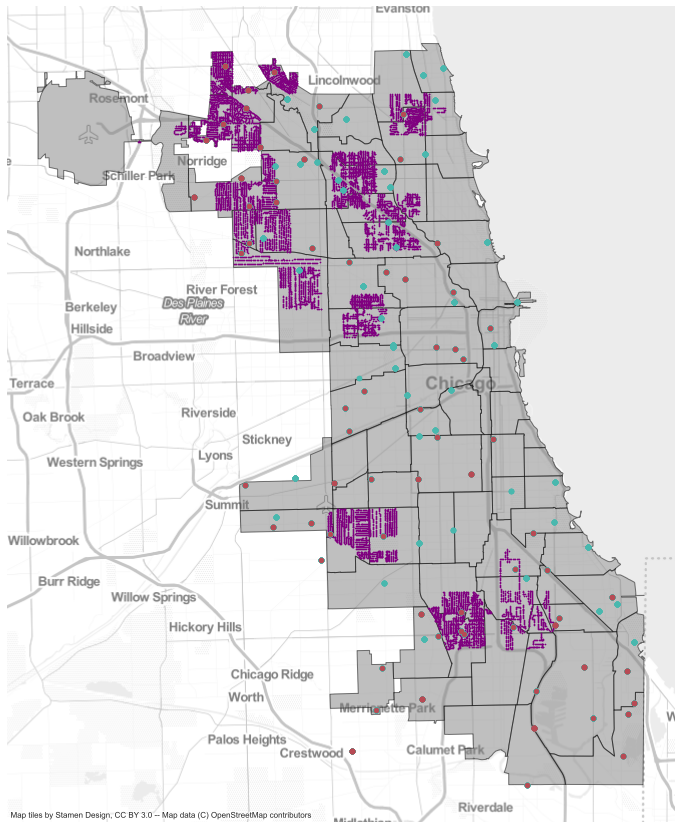

In [55]:
fig, ax = plt.subplots(figsize = (15,15))

p_colors = ["#B84A54", "#49B8AE"]
# Basemap
chicago_map_wm.plot(ax = ax, alpha = 0.5, edgecolor = 'black', color = 'grey') # plot neighborhood boundaries
cx.add_basemap(ax, source = cx.providers.Stamen.TonerLite, alpha = 0.5)

# Spray
df_spray_clean_geo.plot(ax = ax, markersize = 0.5, color = 'purple', marker = 'x')

# Traps
# No WNV
df_train_weather_clean_geo[(df_train_weather_clean_geo['WnvPresent']== 0) & (df_train_weather_clean_geo['Year']==2007)].plot(ax = ax, markersize = 20, color = '#49B8AE')
# Has WNV
df_train_weather_clean_geo[(df_train_weather_clean_geo['WnvPresent']== 1) & (df_train_weather_clean_geo['Year']==2007)].plot(ax = ax, markersize = 20, color = '#B84A54')

plt.axis('off');

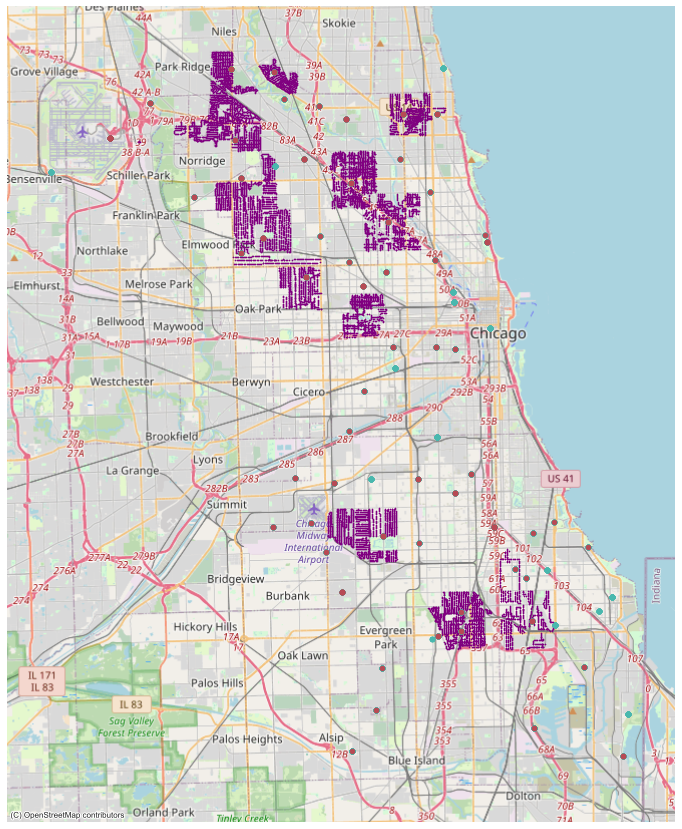

In [50]:
fig, ax = plt.subplots(figsize = (15,15))

p_colors = ["#B84A54", "#49B8AE"]
# Basemap
chicago_map_wm.plot(ax = ax, alpha = 0, edgecolor = 'black', color = 'grey') # plot neighborhood boundaries
cx.add_basemap(ax = ax, source = cx.providers.OpenStreetMap.Mapnik)

# Spray
df_spray_clean_geo.plot(ax = ax, markersize = 0.5, color = 'purple', marker = 'x')

# Traps
# No WNV
df_train_weather_clean_geo[(df_train_weather_clean_geo['WnvPresent']== 0) & (df_train_weather_clean_geo['Year']==2013)].plot(ax = ax, markersize = 20, color = '#49B8AE')
# Has WNV
df_train_weather_clean_geo[(df_train_weather_clean_geo['WnvPresent']== 1) & (df_train_weather_clean_geo['Year']==2013)].plot(ax = ax, markersize = 20, color = '#B84A54')

plt.axis('off');

### Visualizing NumMosquitos and WnvPresent geospatially

In [92]:
df_train_weather_clean_geo.head()

Date  Trap                 Species   Latitude  Longitude  \
0 2007-05-29  T002  CULEX PIPIENS/RESTUANS  41.954690 -87.800991   
1 2007-05-29  T002          CULEX RESTUANS  41.954690 -87.800991   
2 2007-05-29  T007          CULEX RESTUANS  41.994991 -87.769279   
3 2007-05-29  T015  CULEX PIPIENS/RESTUANS  41.974089 -87.824812   
4 2007-05-29  T015          CULEX RESTUANS  41.974089 -87.824812   

   NumMosquitos  WnvPresent  Year  Month  Day  Day of Week  \
0             1           0  2007      5   29            1   
1             1           0  2007      5   29            1   
2             1           0  2007      5   29            1   
3             1           0  2007      5   29            1   
4             4           0  2007      5   29            1   

                           geometry    T001_dist    T002_dist    T003_dist  \
0  POINT (-9773961.609 5154194.640)  5557.466306     0.000000  3747.353616   
1  POINT (-9773961.609 5154194.640)  5557.466306     0.000000  3747.353616   
2  POINT (-9770431.446 5160229.150)  5439.841741  5190.966893  3549.006893   
3  POINT (-9776613.351 5157098.892)  7863.257836  2922.689262  5674.424901   
4  POINT (-9776613.351 5157098.892)  7863.257836  2922.689262  5674.424901   

     T004_dist    T005_dist    T006_dist    T007_dist    T008_dist  \
0  4453.170984  2472.627235  3966.474822  5190.966893  6255.513877   
1  4453.170984  2472.627235  3966.474822  5190.966893  6255.513877   
2  3980.652170  5902.652850  2365.981901     0.000000  1643.934406   
3  6461.084812  5360.263859  2915.454845  5154.517091  5435.831274   
4  6461.084812  5360.263859  2915.454845  5154.517091  5435.831274   

     T009_dist    T011_dist    T012_dist    T013_dist    T014_dist  ...  \
0  3184.307186  2851.317985  6049.358940  3676.277835  2036.530740  ...   
1  3184.307186  2851.317985  6049.358940  3676.277835  2036.530740  ...   
2  3887.918785  7660.549498  1878.795381  8024.761138  3155.635775  ...   
3  1323.540144  3311.799600  6721.030895  6482.075076  3081.569425  ...   
4  1323.540144  3311.799600  6721.030895  6482.075076  3081.569425  ...   

   is_smk_lag_9  Tavg_lag_10  PrecipTotal_lag_10  RH_lag_10  \
0           0.0         68.0                 0.0  34.558252   
1           0.0         68.0                 0.0  34.558252   
2           0.0         68.0                 0.0  34.558252   
3           0.0         68.0                 0.0  34.558252   
4           0.0         68.0                 0.0  34.558252   

   sunlight_hrs_lag_10  ResultSpeed_lag_10  is_wet_lag_10  is_fog_lag_10  \
0                880.0           -7.869152            0.0            0.0   
1                880.0           -7.869152            0.0            0.0   
2                880.0           -7.869152            0.0            0.0   
3                880.0           -7.869152            0.0            0.0   
4                880.0           -7.869152            0.0            0.0   

   is_smk_lag_10  Tavg_lag_11  PrecipTotal_lag_11  RH_lag_11  \
0            0.0         57.0                 0.0  35.568597   
1            0.0         57.0                 0.0  35.568597   
2            0.0         57.0                 0.0  35.568597   
3            0.0         57.0                 0.0  35.568597   
4            0.0         57.0                 0.0  35.568597   

   sunlight_hrs_lag_11  ResultSpeed_lag_11  is_wet_lag_11  is_fog_lag_11  \
0                878.0           -4.156104            0.0            0.0   
1                878.0           -4.156104            0.0            0.0   
2                878.0           -4.156104            0.0            0.0   
3                878.0           -4.156104            0.0            0.0   
4                878.0           -4.156104            0.0            0.0   

   is_smk_lag_11  Tavg_lag_12  PrecipTotal_lag_12  RH_lag_12  \
0            0.0         53.0                 0.0  44.606027   
1            0.0         53.0                 0.0  44.606027   
2            0.

In [93]:
df_train_weather_clean_subset_geo = df_train_weather_clean_geo[['Year', 'Month', 'Trap', 
                                                                'NumMosquitos', 'WnvPresent', 'geometry']]
# group by month, year and trap while summing the numMosquitos and WnvPresent
df_train_weather_clean_subset_geo_grp = df_train_weather_clean_subset_geo.groupby(['Month', 
                                                                                  'Year', 'Trap']).agg({'NumMosquitos':'sum',
                                                                                              'WnvPresent':'sum',
                                                                                            'geometry':'first'}).reset_index()
# add color to each row base on if the virus is present
def add_color(row):
    row['color'] = '#B84A54' if row['WnvPresent'] == 0 else '#49B8AE'
    return row
df_train_weather_clean_subset_geo_grp = df_train_weather_clean_subset_geo_grp.apply(add_color, axis = 1)

# reconvert to gdf after the groupby 
df_train_weather_clean_subset_geo_grp = gpd.GeoDataFrame(df_train_weather_clean_subset_geo_grp, geometry=df_train_weather_clean_subset_geo_grp['geometry'])
df_train_weather_clean_subset_geo_grp.head()

Month  Year  Trap  NumMosquitos  WnvPresent  \
0      5  2007  T002             2           0   
1      5  2007  T007             1           0   
2      5  2007  T015             5           0   
3      5  2007  T045             2           0   
4      5  2007  T046             1           0   

                           geometry    color  
0  POINT (-9773961.609 5154194.640)  #B84A54  
1  POINT (-9770431.446 5160229.150)  #B84A54  
2  POINT (-9776613.351 5157098.892)  #B84A54  
3  POINT (-9758985.130 5149242.729)  #B84A54  
4  POINT (-9757653.304 5144683.377)  #B84A54

C:\Users\weiha\anaconda3\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\weiha\anaconda3\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\weiha\anaconda3\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\weiha\anaconda3\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


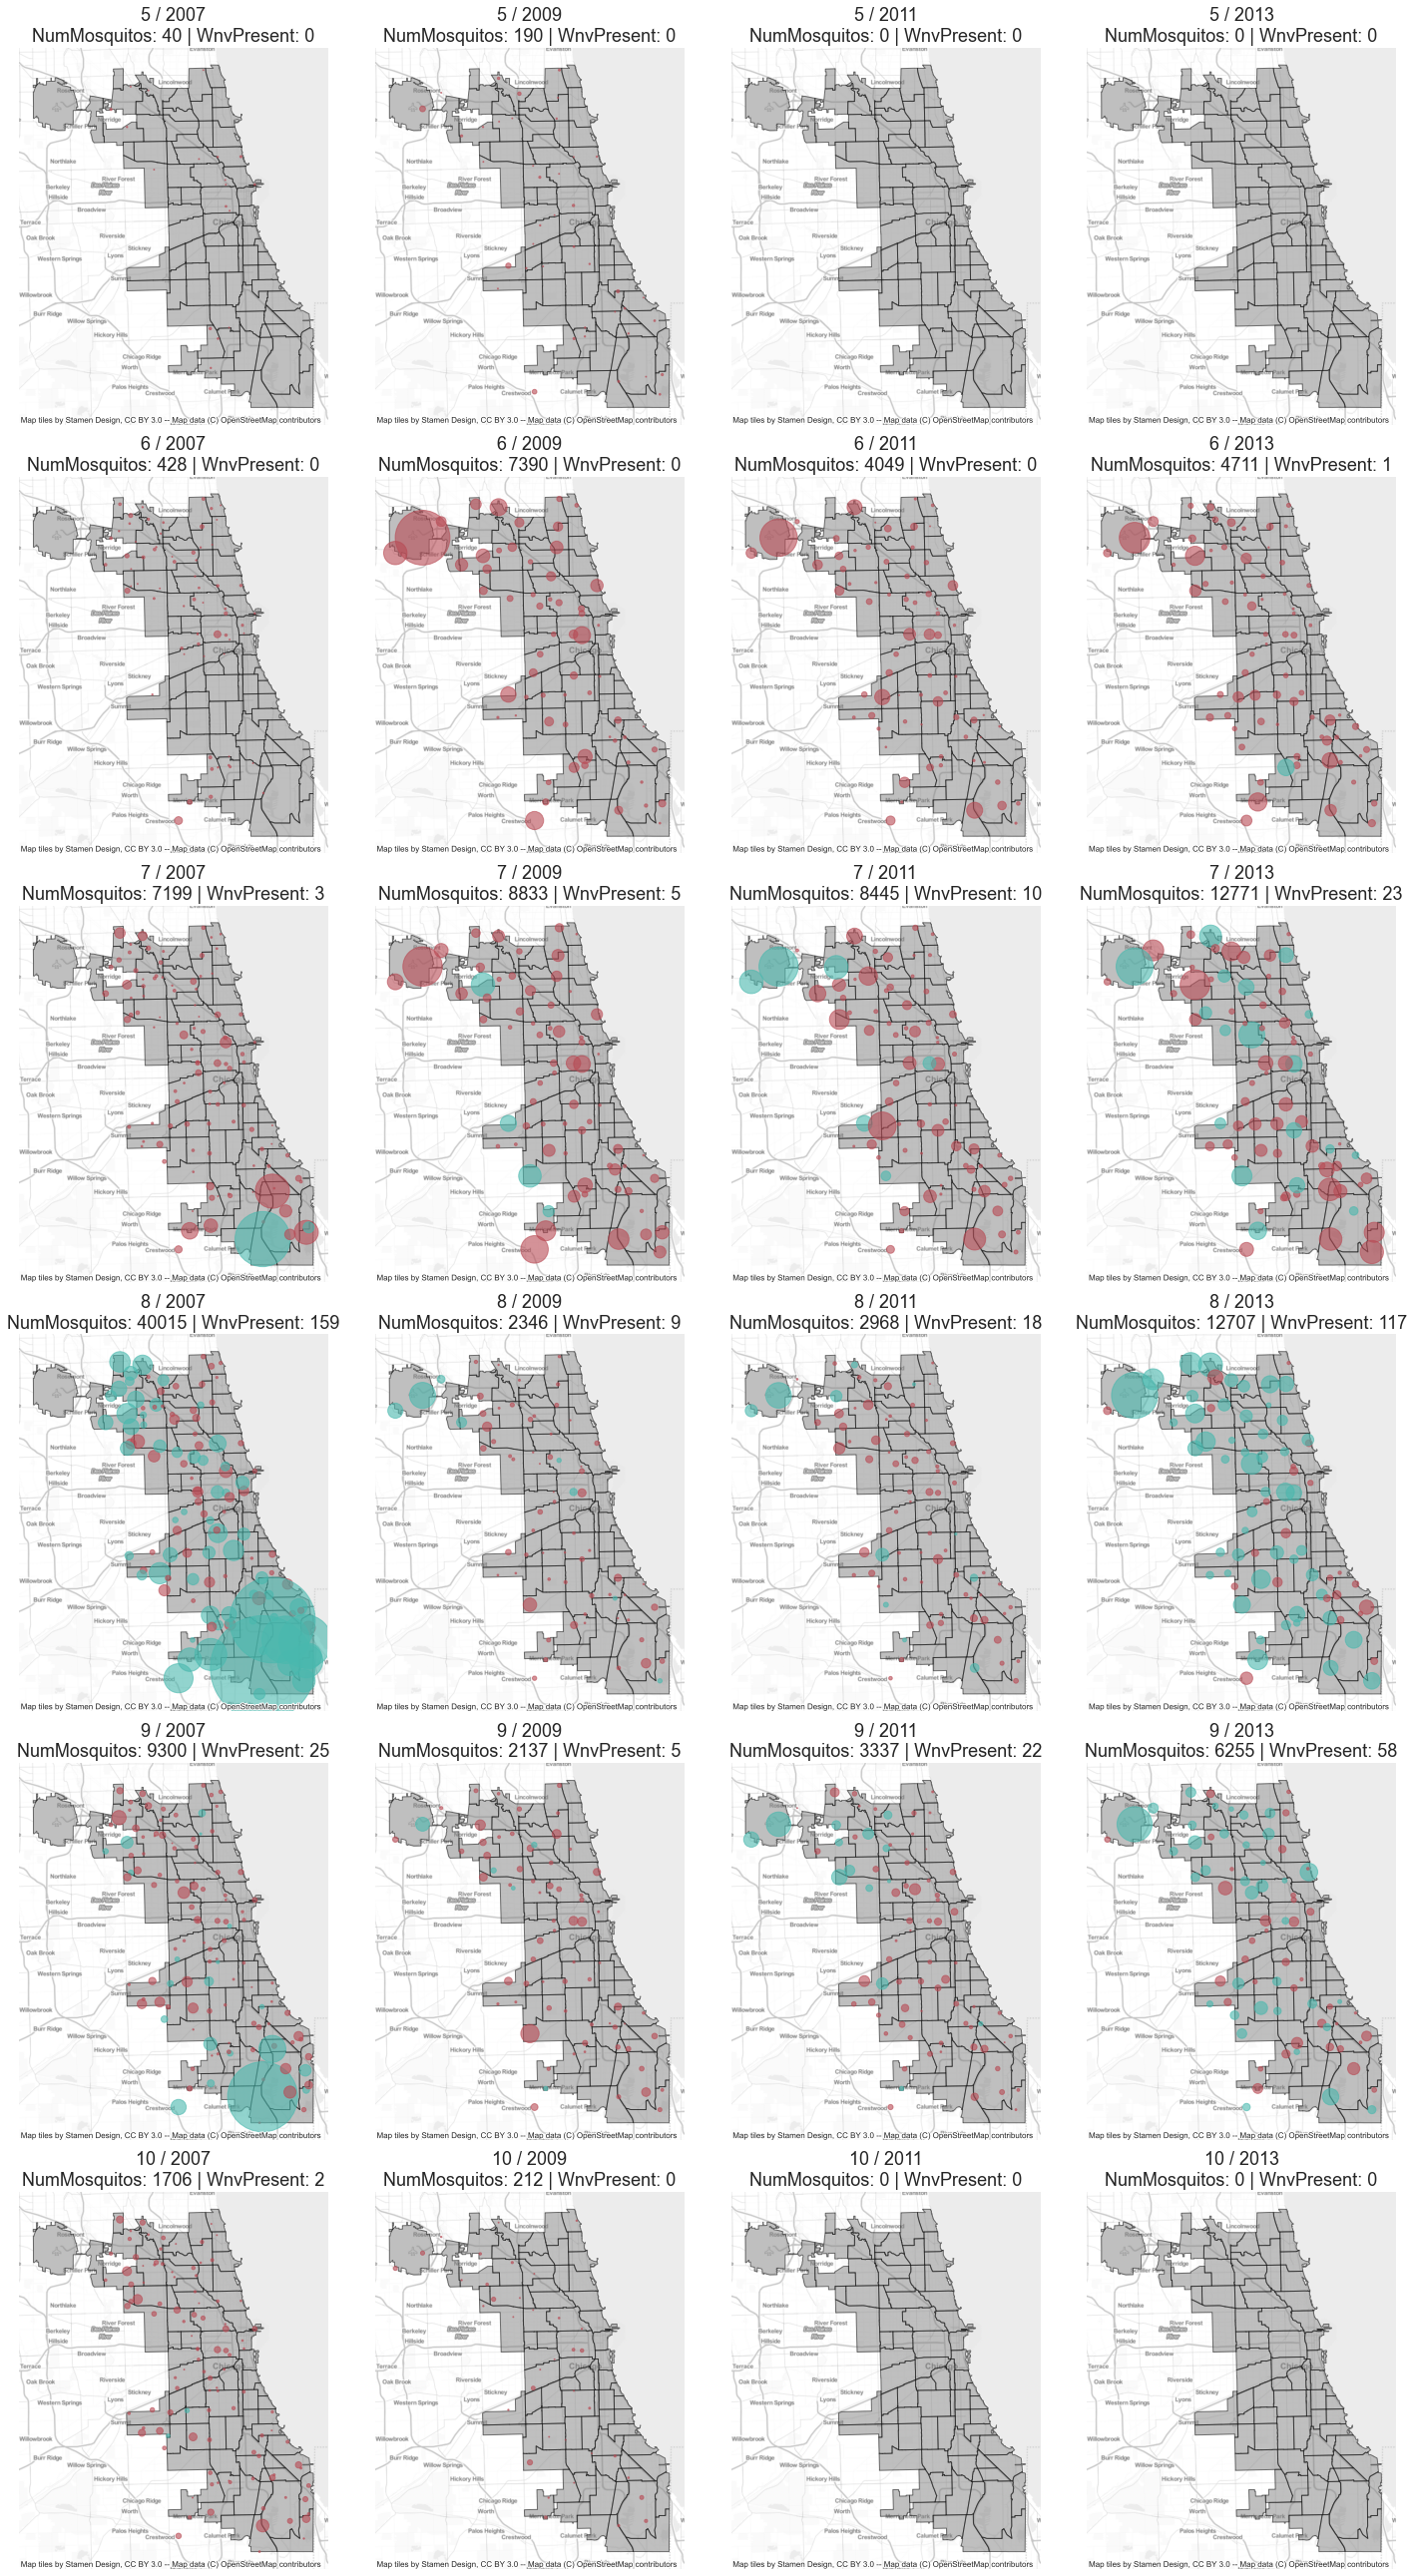

In [94]:
fig, axes = plt.subplots(6, 4, figsize=(20, 36))
plt.tight_layout()

for i, ax_rows in enumerate(axes): # loop through columns - different months
    df_month = df_train_weather_clean_subset_geo_grp[df_train_weather_clean_subset_geo_grp['Month'] == df_train_weather_clean_subset_geo_grp['Month'].unique()[i]]
    for j, ax in enumerate(ax_rows): # loop through rows - different years
        # These are the basemaps
        chicago_map_wm.plot(ax = ax, alpha = 0.5, edgecolor = 'black', color = 'grey')
        cx.add_basemap(ax, source = cx.providers.Stamen.TonerLite, alpha = 0.5)
        
        # These are the trap points
        df_year = df_month[df_month['Year'] == df_train_weather_clean_subset_geo_grp['Year'].unique()[j]]
        df_year.plot(ax = ax,color = df_year['color'], markersize=df_year['NumMosquitos'], alpha = 0.6)
        # Indicate Month and Year
        #ax.set_xlabel(f"NumMosquitos: {df_year['NumMosquitos'].sum()} | WnvPresent: {df_year['WnvPresent'].sum()}")
        ax.set_title(f"{df_train_weather_clean_subset_geo_grp['Month'].unique()[i]} / {df_train_weather_clean_subset_geo_grp['Year'].unique()[j]}\nNumMosquitos: {df_year['NumMosquitos'].sum()} | WnvPresent: {df_year['WnvPresent'].sum()}",
                    fontdict = {'fontsize':18})
        ax.axis('off');

It looks like there are surely some patterns to the mosquitos caught and Wnv present. The higher number of mosquitos and higher number of WNV present tends to concentrate and spead around a few hotspots for different years.

### Moran's spatial autocorrelation

We will also take a look at the spatial autocorrelation by taking a look at the Moran's autocorrelation values for different years.

In [95]:
# Take a look at the dataframe grouped by month and year again
df_train_weather_clean_subset_geo_grp.head()

Month  Year  Trap  NumMosquitos  WnvPresent  \
0      5  2007  T002             2           0   
1      5  2007  T007             1           0   
2      5  2007  T015             5           0   
3      5  2007  T045             2           0   
4      5  2007  T046             1           0   

                           geometry    color  
0  POINT (-9773961.609 5154194.640)  #B84A54  
1  POINT (-9770431.446 5160229.150)  #B84A54  
2  POINT (-9776613.351 5157098.892)  #B84A54  
3  POINT (-9758985.130 5149242.729)  #B84A54  
4  POINT (-9757653.304 5144683.377)  #B84A54

In [96]:
# group by year 
df_train_grp_year = df_train_weather_clean_subset_geo_grp.groupby(['Trap']).agg({'Year':'first',
                                                                                 'NumMosquitos':'sum', 
                                                                                 'WnvPresent':'sum',
                                                                                 'geometry':'first'}).reset_index()
df_train_grp_year = gpd.GeoDataFrame(df_train_grp_year, geometry=df_train_grp_year['geometry'])
df_train_grp_year.head()

Trap  Year  NumMosquitos  WnvPresent                          geometry
0  T001  2007            25           0  POINT (-9766501.311 5154047.198)
1  T002  2007          3710          15  POINT (-9773961.609 5154194.640)
2  T003  2009          1346          14  POINT (-9769135.687 5155624.573)
3  T004  2007            59           0  POINT (-9768103.532 5155397.913)
4  T005  2007            50           2  POINT (-9771222.482 5152312.342)

In [97]:
# Function to compute moran's I by year
def compute_moran(df, year, k, y_name):
    df_by_yr_mth = df[df['Year']==year]
    w = weights.KNN.from_dataframe(df_by_yr_mth, k =k)
    y = df_by_yr_mth[y_name]
    moran_i = pysal.explore.esda.Moran(y,
                                   w,
                                   two_tailed = True,
                                   permutations=1000)
    print(f'------------------ Year: {year}--------------------')
    print('Correlation value: ', moran_i.I)
    print('P-value: ', moran_i.p_sim)

for yr in [2007, 2009, 2011, 2013]:
    compute_moran(df_train_grp_year, year = yr, k=5, y_name = 'WnvPresent')

------------------ Year: 2007--------------------
Correlation value:  0.15988325815866275
P-value:  0.011988011988011988
------------------ Year: 2009--------------------
Correlation value:  0.1186904761904762
P-value:  0.03696303696303696
------------------ Year: 2011--------------------
Correlation value:  -0.1404203718674212
P-value:  0.31368631368631367
------------------ Year: 2013--------------------
Correlation value:  -0.20000000000000004
P-value:  0.000999000999000999


C:\Users\weiha\anaconda3\lib\site-packages\pysal\lib\weights\util.py:1028: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  data = np.vstack([np.array(shape.centroid) for shape in iterable])
C:\Users\weiha\anaconda3\lib\site-packages\pysal\lib\weights\util.py:1028: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  data = np.vstack([np.array(shape.centroid) for shape in iterable])
C:\Users\weiha\anaconda3\lib\site-packages\pysal\lib\weights\util.py:1028: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  data = np.vstack([np.array(shape.centroid) for shape in iterable])
C:\Users\weiha\anaconda3\lib\site-packages\pysal\lib\weights\weights.py:170: UserWarning: The weights matrix is not fully

## Temp

In [501]:
def compute_moran(df, year, month, k, y_name):
    df_by_yr_mth = df[(df['Year'] == year) & (df['Month'] == month)]
    w = weights.KNN.from_dataframe(df_by_yr_mth, k =k)
    y = df_by_yr_mth[y_name]
    moran_i = pysal.explore.esda.Moran(y,
                                   w,
                                   two_tailed = True,
                                   permutations=1000)
    print('Correlation value: ', moran_i.I)
    print('P-value: ', moran_i.p_sim)
    
compute_moran(df_train_weather_clean_subset_geo_grp, year = 2013, month = 8, k=5, y_name = 'NumMosquitos')

Correlation value:  0.05664590375772245
P-value:  0.06393606393606394


C:\Users\weiha\anaconda3\lib\site-packages\pysal\lib\weights\util.py:1028: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  data = np.vstack([np.array(shape.centroid) for shape in iterable])


<AxesSubplot:xlabel='NumMosquitos', ylabel='WnvPresent'>

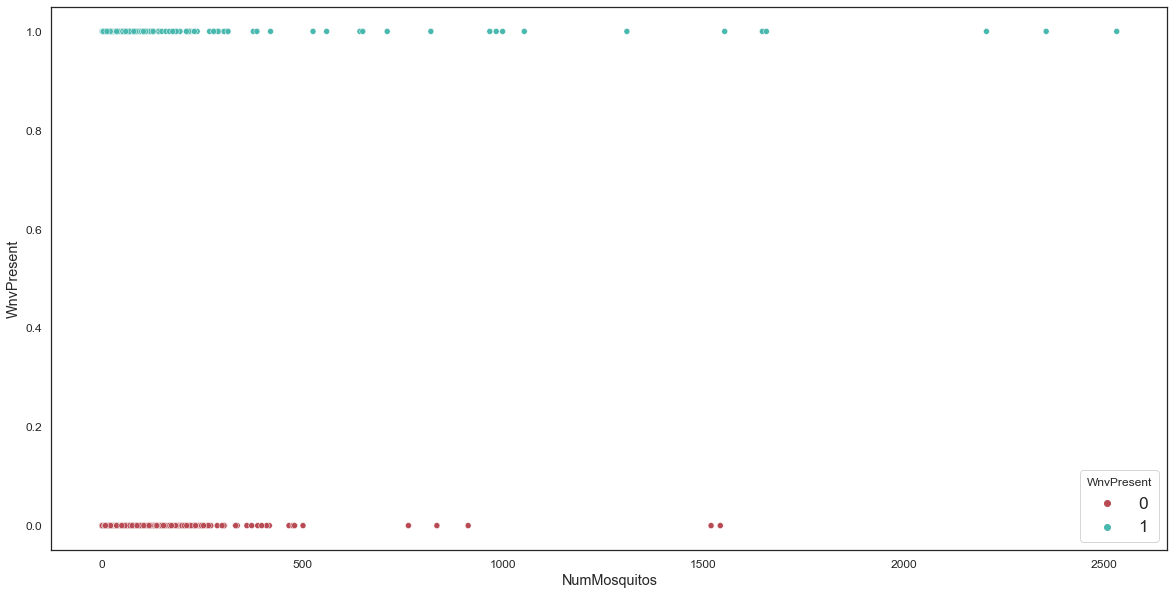

In [352]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.scatterplot(data = df_train_weather_clean, x = 'NumMosquitos', y = 'WnvPresent', hue = 'WnvPresent')

In [51]:
regression_impt = pd.read_csv("../../datasets/cleaned_data/regression_feature_impt.csv")
classification_impt = pd.read_csv("../../datasets/cleaned_data/classification_feature_impt.csv")


In [52]:
regression_impt.head()

Feature  Feature Importance
0             is_restuans/pipiens            0.230102
1                       T900_dist            0.159268
2  Species_CULEX PIPIENS/RESTUANS            0.042306
3          Species_CULEX RESTUANS            0.038890
4                            Tavg            0.030012

In [53]:
classification_impt.head()

Feature  Feature Importance
0     T903_dist            0.057526
1  NumMosquitos            0.055012
2     T036_dist            0.052727
3     T070_dist            0.043668
4     T152_dist            0.036905

In [ ]:
classification_impt

In [ ]:
fig, ax = plt.subplots(figsize = (15,15))

p_colors = ["#B84A54", "#49B8AE"]
# Basemap
chicago_map_wm.plot(ax = ax, alpha = 0, edgecolor = 'black', color = 'grey') # plot neighborhood boundaries
cx.add_basemap(ax = ax, source = cx.providers.OpenStreetMap.Mapnik)

# Spray
df_spray_clean_geo.plot(ax = ax, markersize = 0.5, color = 'purple', marker = 'x')

# Traps
# No WNV
df_train_weather_clean_geo[(df_train_weather_clean_geo['WnvPresent']== 0) & (df_train_weather_clean_geo['Year']==2013)].plot(ax = ax, markersize = 20, color = '#49B8AE')
# Has WNV
df_train_weather_clean_geo[(df_train_weather_clean_geo['WnvPresent']== 1) & (df_train_weather_clean_geo['Year']==2013)].plot(ax = ax, markersize = 20, color = '#B84A54')

plt.axis('off');